In [1]:
using StockFlow

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

using Catlab.Graphics.Graphviz: Html
using Catlab.Graphics.Graphviz

Graph = StockFlow.Graph

# Functions for graphing typed Petri nets
colors_vflow = ["antiquewhite4","antiquewhite", "gold", "saddlebrown", "slateblue", "blueviolet", "olive"]
colors_s = ["deeppink","darkorchid","darkred","coral"] # red series
colors_sv = ["cornflowerblue","cyan4","cyan","chartreuse"] # green and blue series

flatten(fname::Symbol) = "$fname"

function flatten(fname::Tuple)
    names = split(replace(string(fname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_stock(typed_StockFlow::ACSetTransformation, colors) = 
  (p,s) -> ("s$s", Attributes(:label=>sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
                                     :shape=>"square", 
                                     :color=>"black", 
                                     :style=>"filled", 
                                     :fillcolor=>colors[typed_StockFlow[:S](s)]))

def_auxiliaryV(typed_StockFlow::ACSetTransformation, colors)=
  (p, v) -> ("v$v", Attributes(:label=>vname(p,v) isa Tuple where T ? Html(replace(string(vname(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(vname(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[typed_StockFlow[:F](incident(p,v,:fv)...)]))


def_auxiliaryV(colors = colors_vflow)=
  (p, v) -> ("v$v", Attributes(:label=>vname(p,v) isa Tuple where T ? Html(replace(string(vname(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(vname(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[incident(p,v,:fv)...]))



def_sumV(typed_StockFlow::ACSetTransformation, colors) = 
  (p, sv) -> ("sv$sv", Attributes(:label=>svname(p,sv) isa Tuple where T ? Html(replace(string(svname(p,sv)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(svname(p,sv))",
                                       :shape=>"circle", 
                                       :color=>"black",
                                       :fillcolor=>colors[typed_StockFlow[:SV](sv)], 
                                       :style=>"filled"))  


def_flow_V(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[typed_StockFlow[:F](f)]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
end
        
def_flow_noneV(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, f) -> begin
     colorType = colors[typed_StockFlow[:F](f)]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

def_flow_V(colors = colors_vflow)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[f]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
    
end
        
def_flow_noneV(colors = colors_vflow)=
  (p, us, ds, f) -> begin
     colorType = colors[f]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

Graph_typed(typed_StockFlow::ACSetTransformation, colors_vflow = colors_vflow, colors_s = colors_s, colors_sv = colors_sv; schema::String="C", type::String="SFVL", rd::String="LR") = Graph(dom(typed_StockFlow),
    make_stock = def_stock(typed_StockFlow, colors_s), make_auxiliaryV=def_auxiliaryV(typed_StockFlow, colors_vflow), make_sumV=def_sumV(typed_StockFlow, colors_sv), 
    make_flow_V=def_flow_V(typed_StockFlow, colors_vflow), make_flow_noneV=def_flow_noneV(typed_StockFlow, colors_vflow),schema=schema, type=type, rd=rd
)

Graph_typed (generic function with 4 methods)

# 1. Define the type model (structure)

In [2]:
#(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"
SIS_type=StockAndFlowStructure(
    (:Pop_X=>((:births, :newRecovery, :agingX),(:deathsX, :newInfectious, :agingX),(:v_deathsX, :v_newInfectious, :v_agingX),(:NS,:N)),
        :Pop_I=>((:newInfectious, :agingI),(:newRecovery,:deathsI, :agingI),(:v_newRecovery,:v_deathsI, :v_agingI),(:NS,:NI,:N))),
    (:deathsX=>:v_deathsX, :births=>:v_births, :newInfectious=>:v_newInfectious, :newRecovery=>:v_newRecovery,:deathsI=>:v_deathsI,
     :agingX=>:v_agingX,:agingI=>:v_agingI),
    (:N=>:v_births, :NI=>:v_newInfectious, :NS=>:v_newInfectious)
)

StockAndFlowStructure {S:2, SV:3, LS:5, F:7, I:5, O:6, V:7, LV:6, LSV:3, Name:0}
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │ Pop_X │
│ 2 │ Pop_I │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │     NI │
│  3 │     NS │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    3 │
│  2 │   1 │    1 │
│  3 │   2 │    3 │
│  4 │   2 │    2 │
│  5 │   2 │    1 │
└────┴─────┴──────┘
┌───┬────┬───────────────┐
│ F │ fv │         fname │
├───┼────┼───────────────┤
│ 1 │  1 │       deathsX │
│ 2 │  2 │        births │
│ 3 │  3 │ newInfectious │
│ 4 │  4 │   newRecovery │
│ 5 │  5 │       deathsI │
│ 6 │  6 │        agingX │
│ 7 │  7 │        agingI │
└───┴────┴───────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   4 │  1 │
│ 3 │   6 │  1 │
│ 4 │   3 │  2 │
│ 5 │   7 │  2 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   3 │  1 │
│ 3 │   6 │  1 │
│ 4 │   4 │  2 │
│ 5 │   5 │  2 │
│ 6 │   7 │  2 │
└───┴─────┴────┘
┌───┬─────────────────┐
│ V │           vname │
├───┼─────────────────┤
│ 1 │       v_deathsX │
│ 2 │        v_births │
│ 3 │ v_newInfectious │
│ 4 │   v_newRecovery │
│ 5 │       v_deathsI │
│ 6 │        v_agingX │
│ 7 │        v_agingI │
└───┴─────────────────┘
┌────┬─────┬─────┐
│ LV │ lvs │ lvv │
├────┼─────┼─────┤
│  1 │   1 │   1 │
│  2 │   1 │   3 │
│  3 │   1 │   6 │
│  4 │   2 │   4 │
│  5 │   2 │   5 │
│  6 │   2 │   7 │
└────┴─────┴─────┘
┌─────┬───────┬──────┐
│ LSV │ lsvsv │ lsvv │
├─────┼───────┼──────┤
│   1 │     1 │    2 │
│   2 │     2 │    3 │
│   3 │     3 │    3 │
└─────┴───────┴──────┘

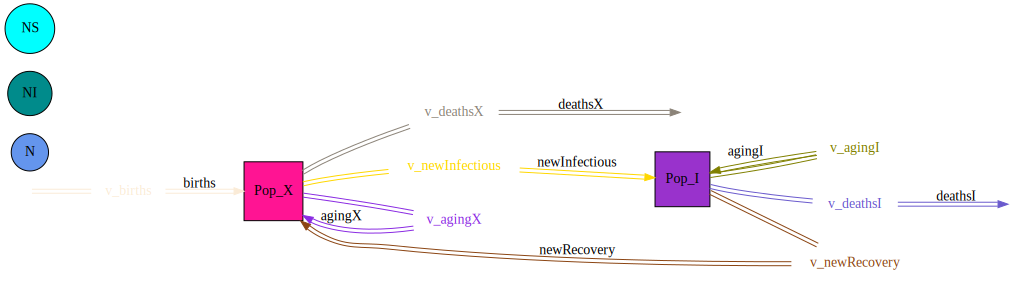

In [3]:
Graph_typed(id(SIS_type); type="SFV")

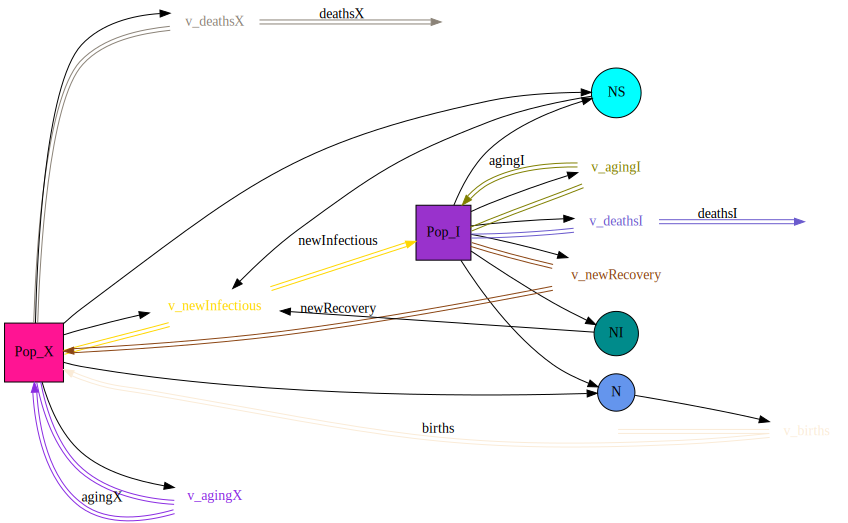

In [4]:
Graph_typed(id(SIS_type))

In [5]:
# eliminate the attribute of name to enable pass the natural check
SIS_type = map(SIS_type, Name=name->nothing);

## 1.1 Define the index name of each part

In [6]:
sX, sI = parts(SIS_type, :S)
sv_N, sv_NI, sv_NS = parts(SIS_type, :SV)
lsn_X_NS, lsn_X_N, lsn_I_NS, lsn_I_NI, lsn_I_N = parts(SIS_type, :LS)
f_deathsX, f_births, f_newInfectious, f_newRecovery, f_deathsI, f_agingX, f_agingI = parts(SIS_type, :F)
i_births, i_newRecovery, i_agingX, i_newInfectious, i_agingI = parts(SIS_type, :I)
o_deathsX, o_newInfectious, o_agingX, o_newRecovery, o_deathsI, o_agingI = parts(SIS_type, :O)
v_deathsX, v_births, v_newInfectious, v_newRecovery, v_deathsI, v_agingX, v_agingI = parts(SIS_type, :V)
lv_deathsX, lv_newInfectious, lv_agingX, lv_newRecovery, lv_deathsI, lv_agingI = parts(SIS_type, :LV)
lsv_N_births, lsv_NI_newInfectious, lsv_NS_newInfectious = parts(SIS_type, :LSV)

1:3

# 2. Build the aggregate population model by composition
Define the components of all the sub-models
## 2.1 The births and deaths of Stock X

In [7]:
# define function of concatenate of two strings to symbol
# s1,s2: String
fsymbol(s1,s2)=Symbol(s1*s2)

fsymbol (generic function with 1 method)

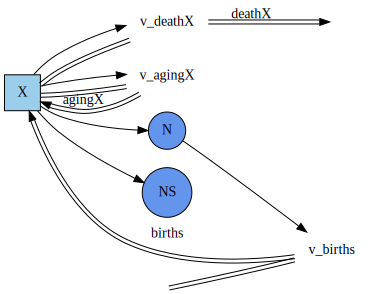

In [8]:
#(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"
openX=Open(
    StockAndFlowStructure(
    (:X=>((:births,:agingX),(:deathX,:agingX),(:v_deathX,:v_agingX),(:N,:NS))),
    (:births=>:v_births,:deathX=>:v_deathX,:agingX=>:v_agingX),
    (:N=>:v_births,:NS=>:SVV_NONE)
    ),
    # feet
    foot(:X,:N,:X=>:N),
    foot(:X,:NS,:X=>:NS)
)
Graph(apex(openX))

## 2.2 The SIS sub-model structure

In [9]:
#(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"

# I: string of stock "A" or "Y"
# r: symbol of the constant parameter σ or σ′
# f: function of fInfectiousA or fInfectiousY
openSIS(I,r)=Open(
    StockAndFlowStructure(
    (:X=>(fsymbol("recovery",I),fsymbol("newInfectious",I),fsymbol("v_newInfectious",I),(:N,:NS)),
     Symbol(I)=>((fsymbol("newInfectious",I),fsymbol("aging",I)),(fsymbol("death",I), fsymbol("recovery",I),fsymbol("aging",I)),(fsymbol("v_death",I), fsymbol("v_recovery",I),fsymbol("v_aging",I)),(:N,:NI, :NS))),
    (fsymbol("recovery",I)=>fsymbol("v_recovery",I),fsymbol("newInfectious",I)=>fsymbol("v_newInfectious",I),fsymbol("death",I)=>fsymbol("v_death",I),fsymbol("aging",I)=>fsymbol("v_aging",I)),
    (:NS=>fsymbol("v_newInfectious",I), :NI=>fsymbol("v_newInfectious",I), :N=>:SVV_NONE)
    ),
    # feet
    foot(:X,:N,:X=>:N),
    foot(:X,:NS,:X=>:NS),
    foot((),:NI,())
)


openSIS (generic function with 1 method)

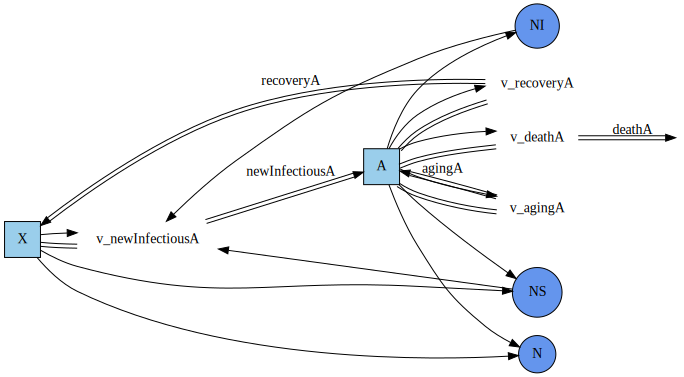

In [10]:
Graph(apex(openSIS("A",:σ′)))

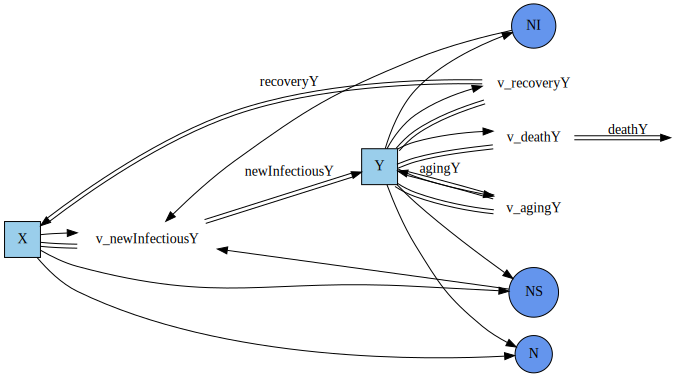

In [11]:
Graph(apex(openSIS("Y",:σ)))

## 2.3 Compose
### 2.3.1 Define composition rule

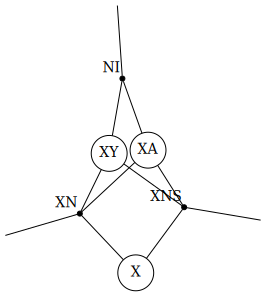

In [12]:
# define the UWD-algebra
uwd = @relation (XN,XNS,NI) begin
    X(XN,XNS)
    XA(XN,XNS,NI)
    XY(XN,XNS,NI)
end;
display_uwd(uwd)

### 2.3.2 Composition

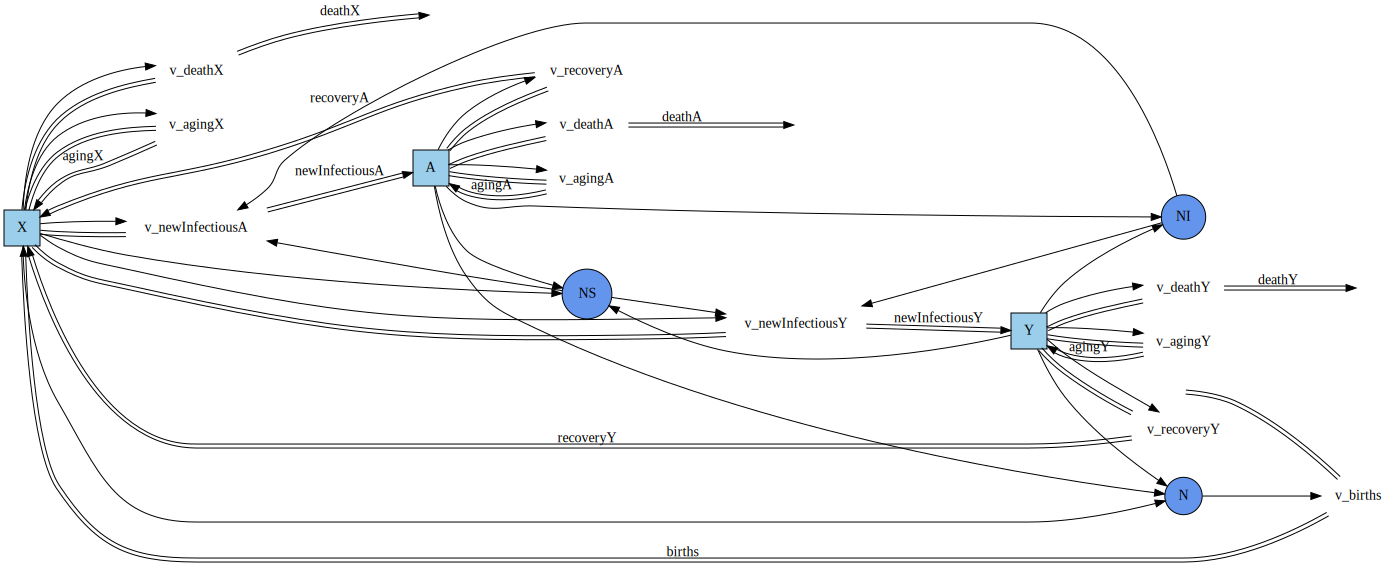

In [13]:
XAY_model = oapply(uwd,Dict(
    :X=>openX,
    :XA=>openSIS("A",:σ′),
    :XY=>openSIS("Y",:σ)
    )) |> apex
Graph(XAY_model)

## 2.4 Homomorphism of typed aggregate model

In [14]:
typed_aggregate_model=ACSetTransformation(XAY_model, SIS_type,
  S = [sX, sI, sI],
  SV = [sv_N, sv_NS, sv_NI],
  LS = [lsn_X_N, lsn_X_NS, lsn_I_N, lsn_I_NI, lsn_I_NS, lsn_I_N, lsn_I_NI, lsn_I_NS],   
  F = [f_births, f_deathsX, f_agingX, f_newRecovery, f_newInfectious, f_deathsI, f_agingI, f_newRecovery, f_newInfectious, f_deathsI, f_agingI],    
  I = [i_births, i_agingX, i_newRecovery, i_newInfectious, i_agingI, i_newRecovery, i_newInfectious, i_agingI], 
  O = [o_deathsX, o_agingX, o_newInfectious, o_deathsI, o_newRecovery, o_agingI, o_newInfectious, o_deathsI, o_newRecovery, o_agingI],
  V = [v_births, v_deathsX, v_agingX, v_newRecovery, v_newInfectious, v_deathsI, v_agingI, v_newRecovery, v_newInfectious, v_deathsI, v_agingI],
  LV = [lv_deathsX, lv_agingX, lv_newInfectious, lv_deathsI, lv_newRecovery, lv_agingI, lv_newInfectious, lv_deathsI, lv_newRecovery, lv_agingI],
  LSV = [lsv_N_births, lsv_NS_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NI_newInfectious],
  Name = name -> nothing  
)

ACSetTransformation((S = FinFunction([1, 2, 2], 3, 2), SV = FinFunction([1, 3, 2], 3, 3), LS = FinFunction([2, 1, 5, 4, 3, 5, 4, 3], 8, 5), F = FinFunction([2, 1, 6, 4, 3, 5, 7, 4, 3, 5, 7], 11, 7), I = FinFunction([1, 3, 2, 4, 5, 2, 4, 5], 8, 5), O = FinFunction([1, 3, 2, 5, 4, 6, 2, 5, 4, 6], 10, 6), V = FinFunction([2, 1, 6, 4, 3, 5, 7, 4, 3, 5, 7], 11, 7), LV = FinFunction([1, 3, 2, 5, 4, 6, 2, 5, 4, 6], 10, 6), LSV = FinFunction([1, 3, 2, 3, 2], 5, 3), Name = LooseVarFunction{Symbol, Nothing}(FinDomFunction(Union{Nothing, AttrVar}[], FinSet(0), TypeSet(Union{Nothing, AttrVar})), SetFunction(#30, TypeSet(Symbol), TypeSet(Nothing)), FinSet(0))), StockAndFlowStructure {S:3, SV:3, LS:8, F:11, I:8, O:10, V:11, LV:10, LSV:5, Name:0}, StockAndFlowStructureUntyped{Nothing} {S:2, SV:3, LS:5, F:7, I:5, O:6, V:7, LV:6, LSV:3, Name:0})

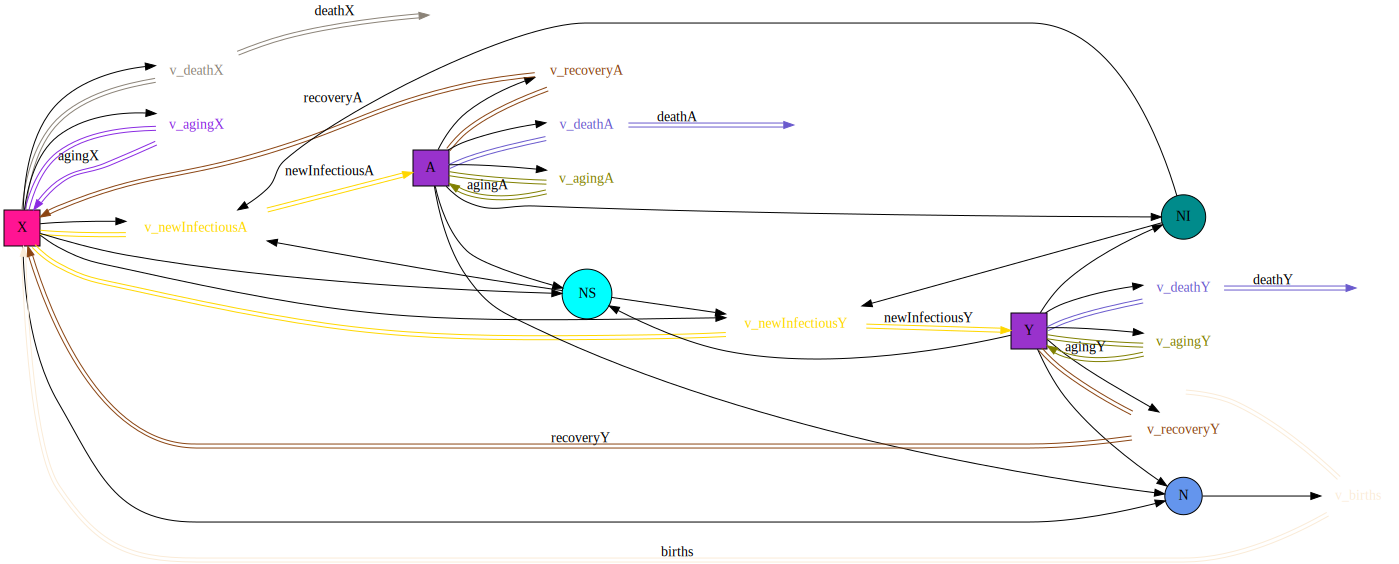

In [15]:
@assert is_natural(typed_aggregate_model)
Graph_typed(typed_aggregate_model)

# 3. Build sex strata model (structure)

In [16]:
## 
#(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"
sex_strata=StockAndFlowStructure(
    (:XF=>((:birthsF, :newRecoveryF),(:deathsXF, :newInfectiousF),(:v_deathsXF, :v_newInfectiousF),(:NS_F,:N)),
        :IF=>(:newInfectiousF,(:newRecoveryF, :deathsIF),(:v_newRecoveryF, :v_deathsIF),(:NS_F,:NI_F,:N)),
        :XM=>((:birthsM, :newRecoveryM),(:deathsXM, :newInfectiousM),(:v_deathsXM, :v_newInfectiousM),(:NS_M,:N)),
        :IM=>(:newInfectiousM,(:newRecoveryM, :deathsIM),(:v_newRecoveryM, :v_deathsIM),(:NS_M,:NI_M,:N))),
    (:birthsF=>:v_birthsF, :newRecoveryF=>:v_newRecoveryF, :newInfectiousF=>:v_newInfectiousF, :deathsXF=>:v_deathsXF, :deathsIF=>:v_deathsIF,
     :birthsM=>:v_birthsM, :newRecoveryM=>:v_newRecoveryM, :newInfectiousM=>:v_newInfectiousM, :deathsXM=>:v_deathsXM, :deathsIM=>:v_deathsIM),
    (:N=>(:v_birthsF,:v_birthsM), :NI_F=>(:v_newInfectiousF,:v_newInfectiousM), :NS_F=>(:v_newInfectiousF,:v_newInfectiousM),
                                  :NI_M=>(:v_newInfectiousF,:v_newInfectiousM), :NS_M=>(:v_newInfectiousF,:v_newInfectiousM))
)

S,sname
1,XF
2,IF
3,XM
4,IM
SV,svname
1,N
2,NI_F
3,NS_F
4,NI_M
5,NS_M


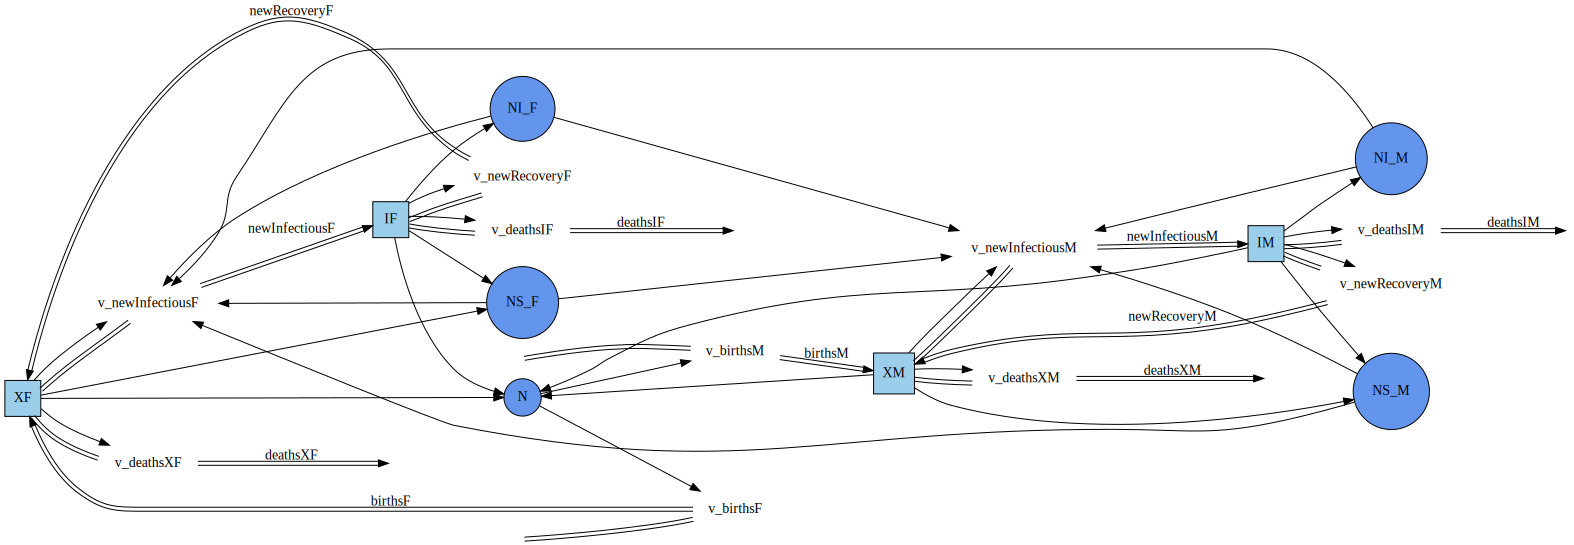

In [17]:
Graph(sex_strata)

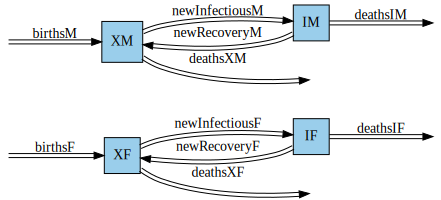

In [18]:
Graph(sex_strata,type="SF")

## 3.1 Homomorphism of  typed sex model

In [19]:
typed_sex_strata=ACSetTransformation(sex_strata, SIS_type,
  S = [sX, sI, sX, sI],
  SV = [sv_N, sv_NI, sv_NS, sv_NI, sv_NS],
  LS = [lsn_X_NS, lsn_X_N, lsn_I_NS, lsn_I_NI, lsn_I_N, lsn_X_NS, lsn_X_N, lsn_I_NS, lsn_I_NI, lsn_I_N],     
  F = [f_births, f_newRecovery, f_newInfectious, f_deathsX, f_deathsI, f_births, f_newRecovery, f_newInfectious, f_deathsX, f_deathsI],      
  I = [i_births, i_newRecovery, i_newInfectious, i_births, i_newRecovery, i_newInfectious], 
  O = [o_deathsX, o_newInfectious, o_newRecovery, o_deathsI, o_deathsX, o_newInfectious, o_newRecovery, o_deathsI],
  V = [v_births, v_newRecovery, v_newInfectious, v_deathsX, v_deathsI, v_births, v_newRecovery, v_newInfectious, v_deathsX, v_deathsI],      
  LV = [lv_deathsX, lv_newInfectious, lv_newRecovery, lv_deathsI, lv_deathsX, lv_newInfectious, lv_newRecovery, lv_deathsI],
  LSV = [lsv_N_births, lsv_N_births, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious],
  Name = name -> nothing  
)

ACSetTransformation((S = FinFunction([1, 2, 1, 2], 4, 2), SV = FinFunction([1, 2, 3, 2, 3], 5, 3), LS = FinFunction([1, 2, 3, 4, 5, 1, 2, 3, 4, 5], 10, 5), F = FinFunction([2, 4, 3, 1, 5, 2, 4, 3, 1, 5], 10, 7), I = FinFunction([1, 2, 4, 1, 2, 4], 6, 5), O = FinFunction([1, 2, 4, 5, 1, 2, 4, 5], 8, 6), V = FinFunction([2, 4, 3, 1, 5, 2, 4, 3, 1, 5], 10, 7), LV = FinFunction([1, 2, 4, 5, 1, 2, 4, 5], 8, 6), LSV = FinFunction([1, 1, 2, 2, 3, 3, 2, 2, 3, 3], 10, 3), Name = LooseVarFunction{Symbol, Nothing}(FinDomFunction(Union{Nothing, AttrVar}[], FinSet(0), TypeSet(Union{Nothing, AttrVar})), SetFunction(#32, TypeSet(Symbol), TypeSet(Nothing)), FinSet(0))), StockAndFlowStructure {S:4, SV:5, LS:10, F:10, I:6, O:8, V:10, LV:8, LSV:10, Name:0}, StockAndFlowStructureUntyped{Nothing} {S:2, SV:3, LS:5, F:7, I:5, O:6, V:7, LV:6, LSV:3, Name:0})

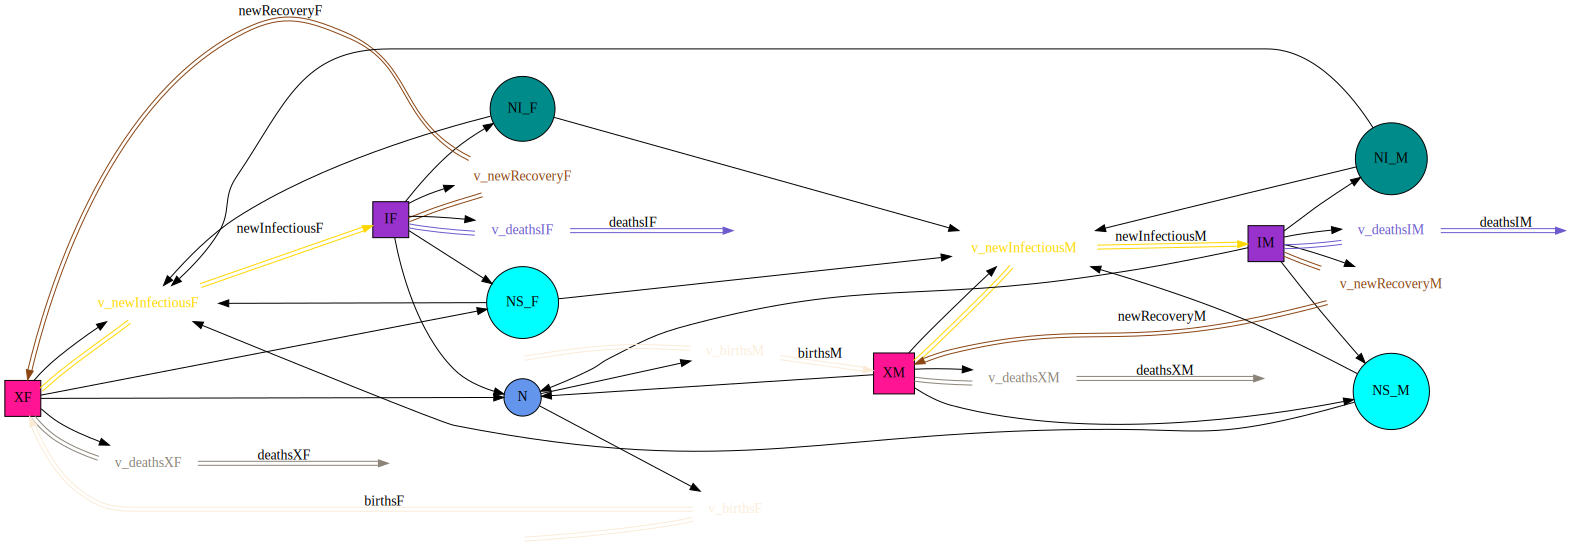

In [20]:
@assert is_natural(typed_sex_strata)
Graph_typed(typed_sex_strata)

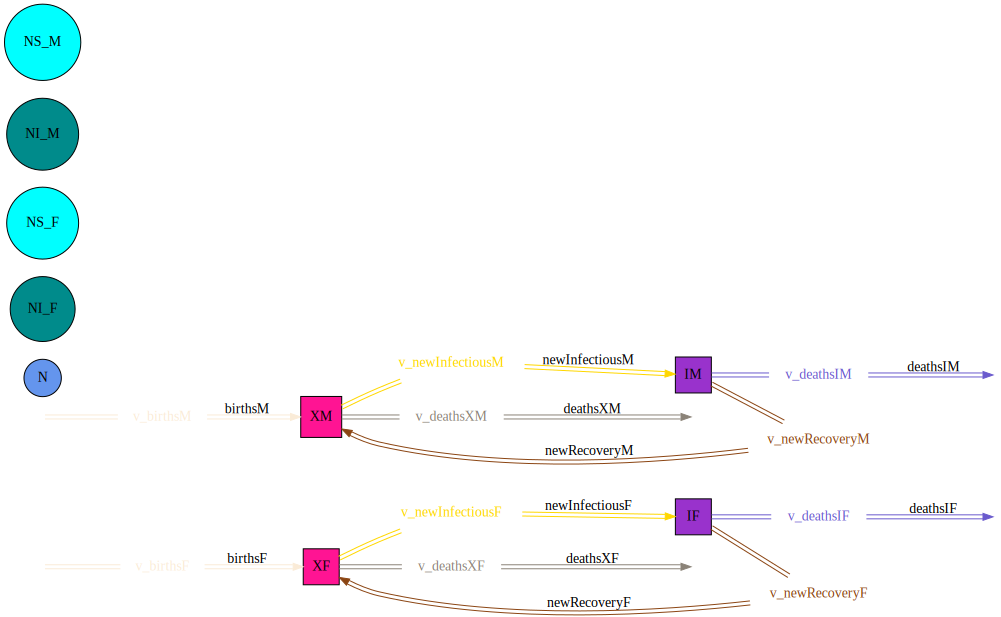

In [21]:
Graph_typed(typed_sex_strata; type="SFV")

# 4. Build the stratified SIS model (by SEX dimension) using pull back

In [22]:
sex_model = pullback(typed_aggregate_model, typed_sex_strata)
apex(sex_model)

S,sname
1,"(:X, :XF)"
2,"(:A, :IF)"
3,"(:Y, :IF)"
4,"(:X, :XM)"
5,"(:A, :IM)"
6,"(:Y, :IM)"
SV,svname
1,"(:N, :N)"
2,"(:NI, :NI_F)"
3,"(:NS, :NS_F)"


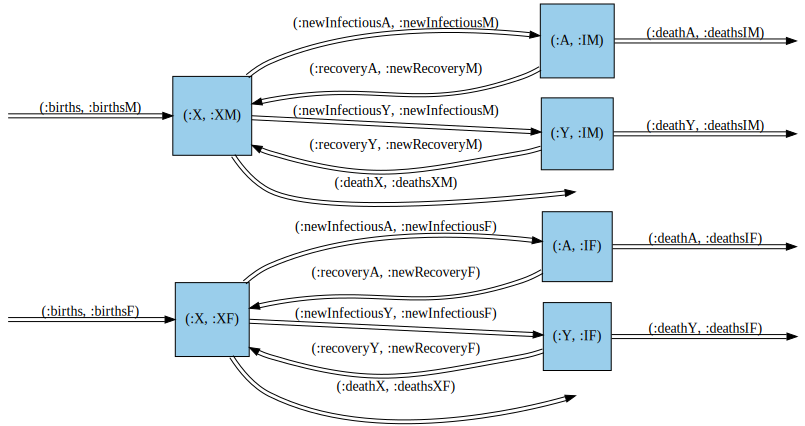

In [23]:
Graph(apex(sex_model),type="SF")

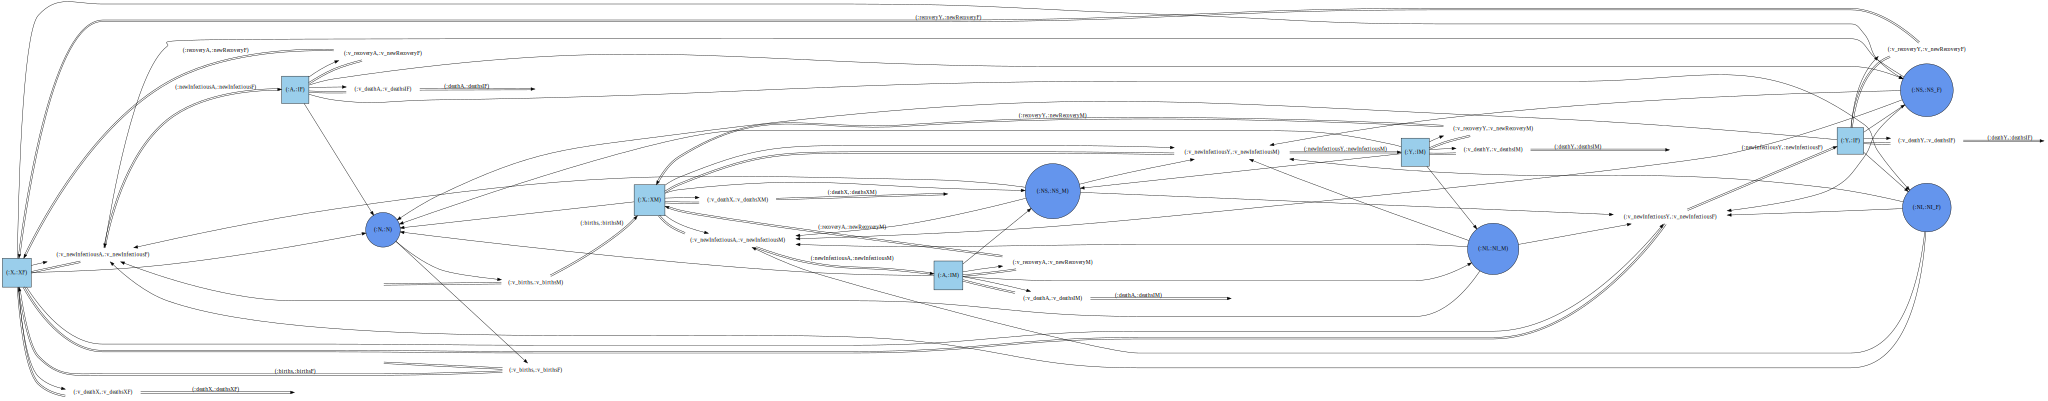

In [24]:
Graph(apex(sex_model))

In [25]:
# Plot the typed stock and flow diagram
stratify(typed_model1, typed_model2) = ob(pullback(typed_model1, typed_model2))

typed_stratify(typed_model1, typed_model2) =
  compose(proj1(pullback(typed_model1, typed_model2)), typed_model1);

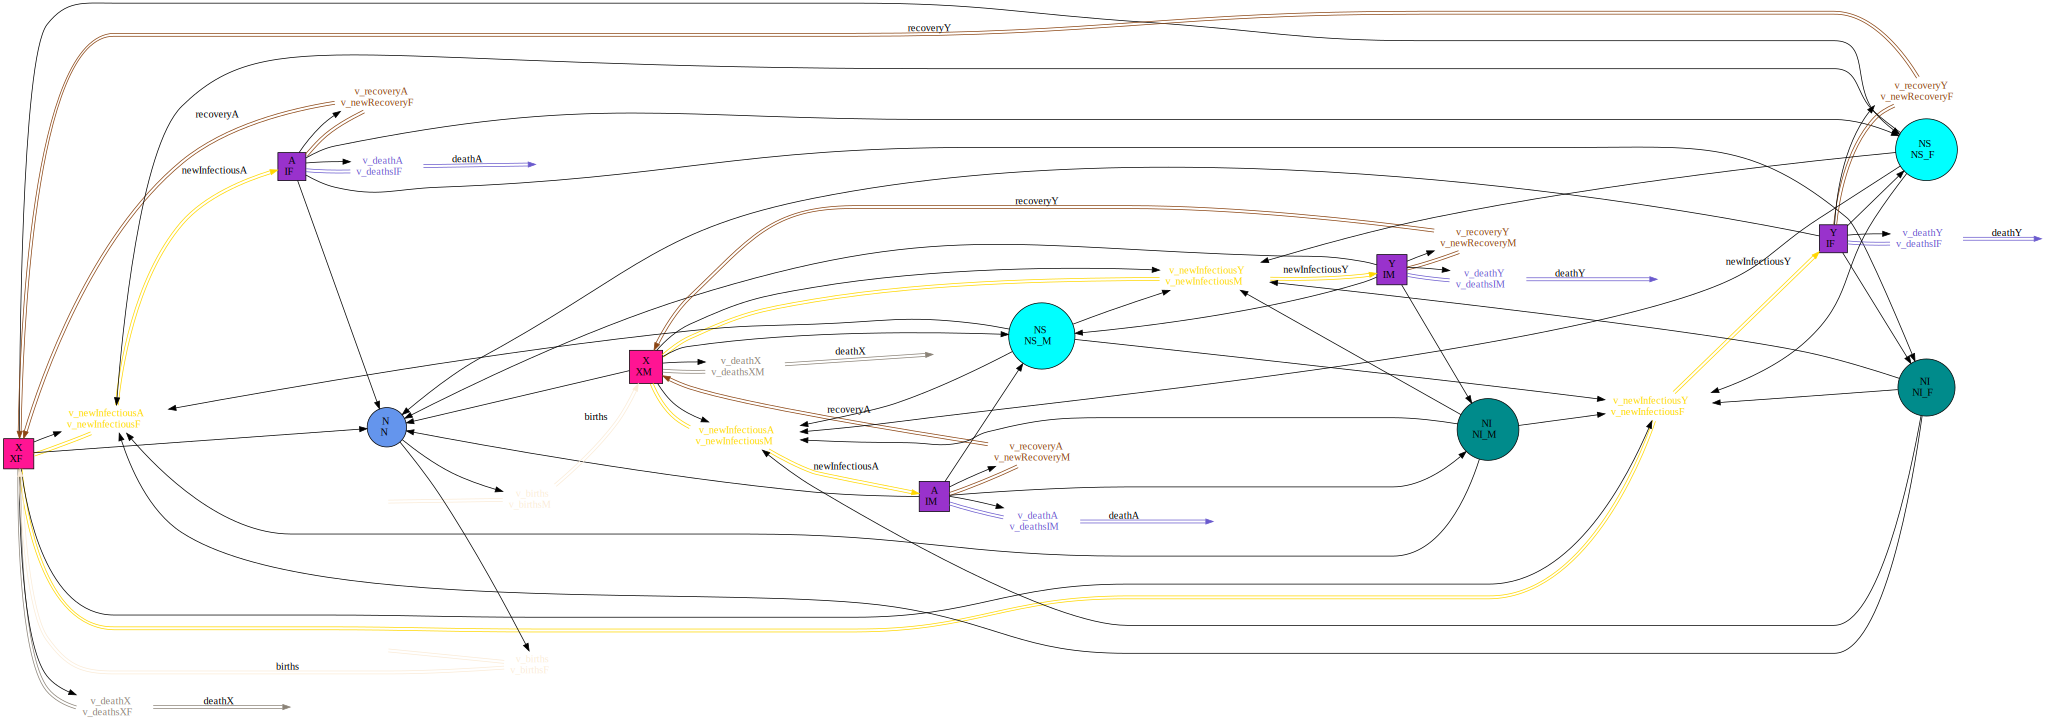

In [26]:
typed_sex_model = typed_stratify(typed_aggregate_model, typed_sex_strata)
Graph_typed(typed_sex_model)

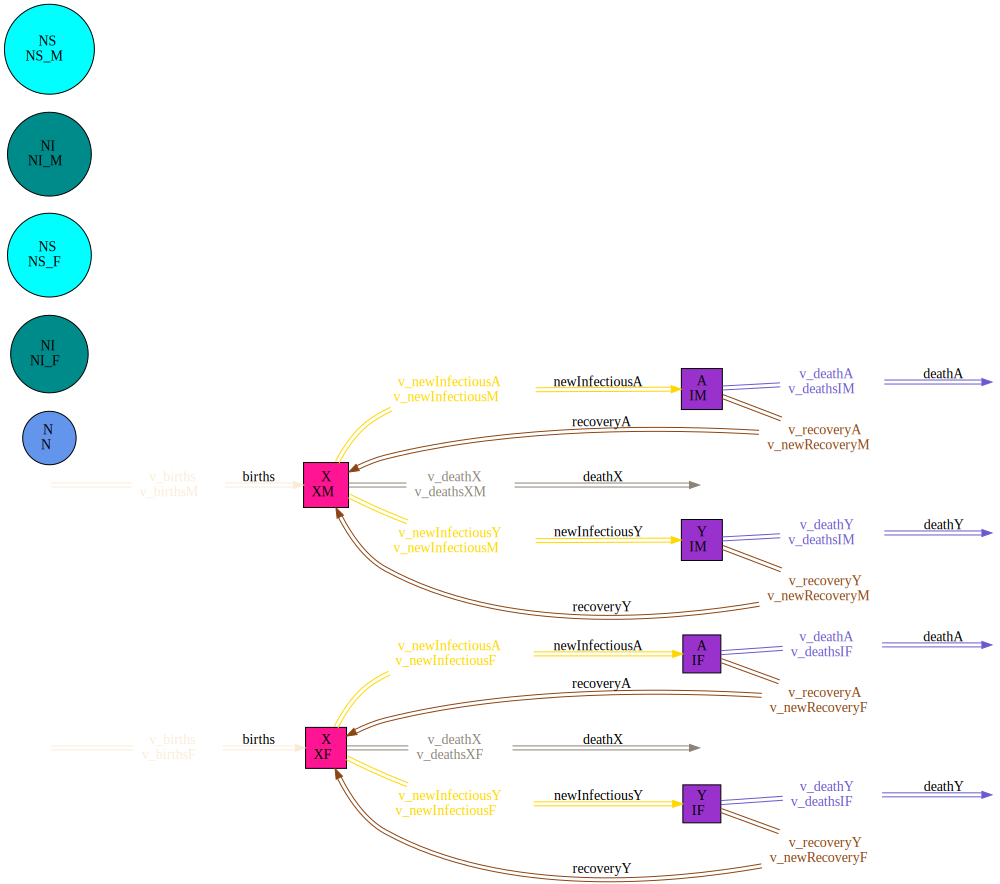

In [27]:
Graph_typed(typed_sex_model; type="SFV")

# 5. Build the age strata model (structure)

In [28]:
## 
#(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"
age_strata=StockAndFlowStructure(
    (:XChild=>((:births,:newRecoveryIChild),(:deathsXChild,:agingXChild,:newInfectiousXChild),(:v_deathsXChild,:v_agingXChild,:v_newInfectiousXChild),(:NS_Child,:N)),
        :IChild=>(:newInfectiousXChild,(:newRecoveryIChild,:agingIChild,:deathsIChild),(:v_newRecoveryIChild,:v_agingIChild,:v_deathsIChild),(:NS_Child,:NI_Child,:N)),
        :XAdult=>((:agingXChild,:newRecoveryIAdult),(:deathsXAdult,:agingXAdult,:newInfectiousXAdult),(:v_deathsXAdult,:v_agingXAdult, :v_newInfectiousXAdult),(:NS_Adult,:N)),
        :IAdult=>((:agingIChild,:newInfectiousXAdult),(:newRecoveryIAdult,:agingIAdult,:deathsIAdult),(:v_newRecoveryIAdult,:v_agingIAdult,:v_deathsIAdult),(:NS_Adult,:NI_Adult,:N)),
        :XSenior=>((:newRecoveryISenior,:agingXAdult),(:deathsXSenior, :newInfectiousXSenior),(:v_deathsXSenior, :v_newInfectiousXSenior),(:NS_Senior,:N)),
        :ISenior=>((:newInfectiousXSenior,:agingIAdult),(:newRecoveryISenior,:deathsISenior),(:v_newRecoveryISenior,:v_deathsISenior),(:NS_Senior,:NI_Senior,:N))),
    (:births=>:v_births,:newInfectiousXChild=>:v_newInfectiousXChild,:newInfectiousXAdult=>:v_newInfectiousXAdult,:newInfectiousXSenior=>:v_newInfectiousXSenior,
        :newRecoveryIChild=>:v_newRecoveryIChild,:newRecoveryIAdult=>:v_newRecoveryIAdult,:newRecoveryISenior=>:v_newRecoveryISenior,
        :agingXChild=>:v_agingXChild,:agingIChild=>:v_agingIChild,:agingXAdult=>:v_agingXAdult,:agingIAdult=>:v_agingIAdult,
        :deathsXChild=>:v_deathsXChild,:deathsXAdult=>:v_deathsXAdult,:deathsXSenior=>:v_deathsXSenior,:deathsIChild=>:v_deathsIChild,:deathsIAdult=>:v_deathsIAdult,:deathsISenior=>:v_deathsISenior),
    (:N=>:v_births, :NI_Child=>(:v_newInfectiousXChild,:v_newInfectiousXAdult,:v_newInfectiousXSenior), :NS_Child=>(:v_newInfectiousXChild,:v_newInfectiousXAdult,:v_newInfectiousXSenior),
                  :NI_Adult=>(:v_newInfectiousXChild,:v_newInfectiousXAdult,:v_newInfectiousXSenior), :NS_Adult=>(:v_newInfectiousXChild,:v_newInfectiousXAdult,:v_newInfectiousXSenior),
                  :NI_Senior=>(:v_newInfectiousXChild,:v_newInfectiousXAdult,:v_newInfectiousXSenior), :NS_Senior=>(:v_newInfectiousXChild,:v_newInfectiousXAdult,:v_newInfectiousXSenior))
)

S,sname
1,XChild
2,IChild
3,XAdult
4,IAdult
5,XSenior
6,ISenior
SV,svname
1,N
2,NI_Child
3,NS_Child


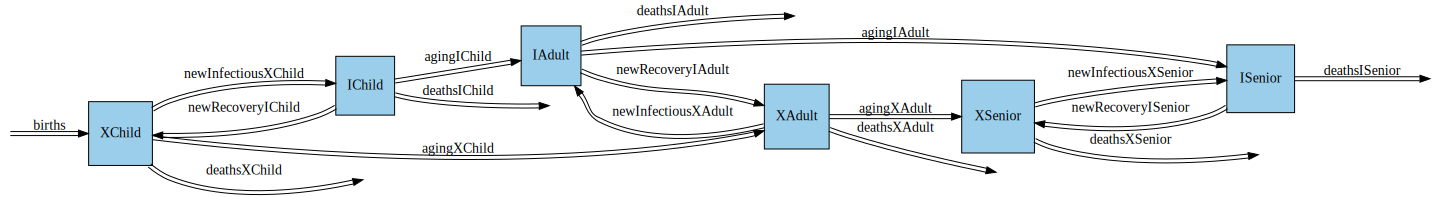

In [29]:
Graph(age_strata, type="SF")

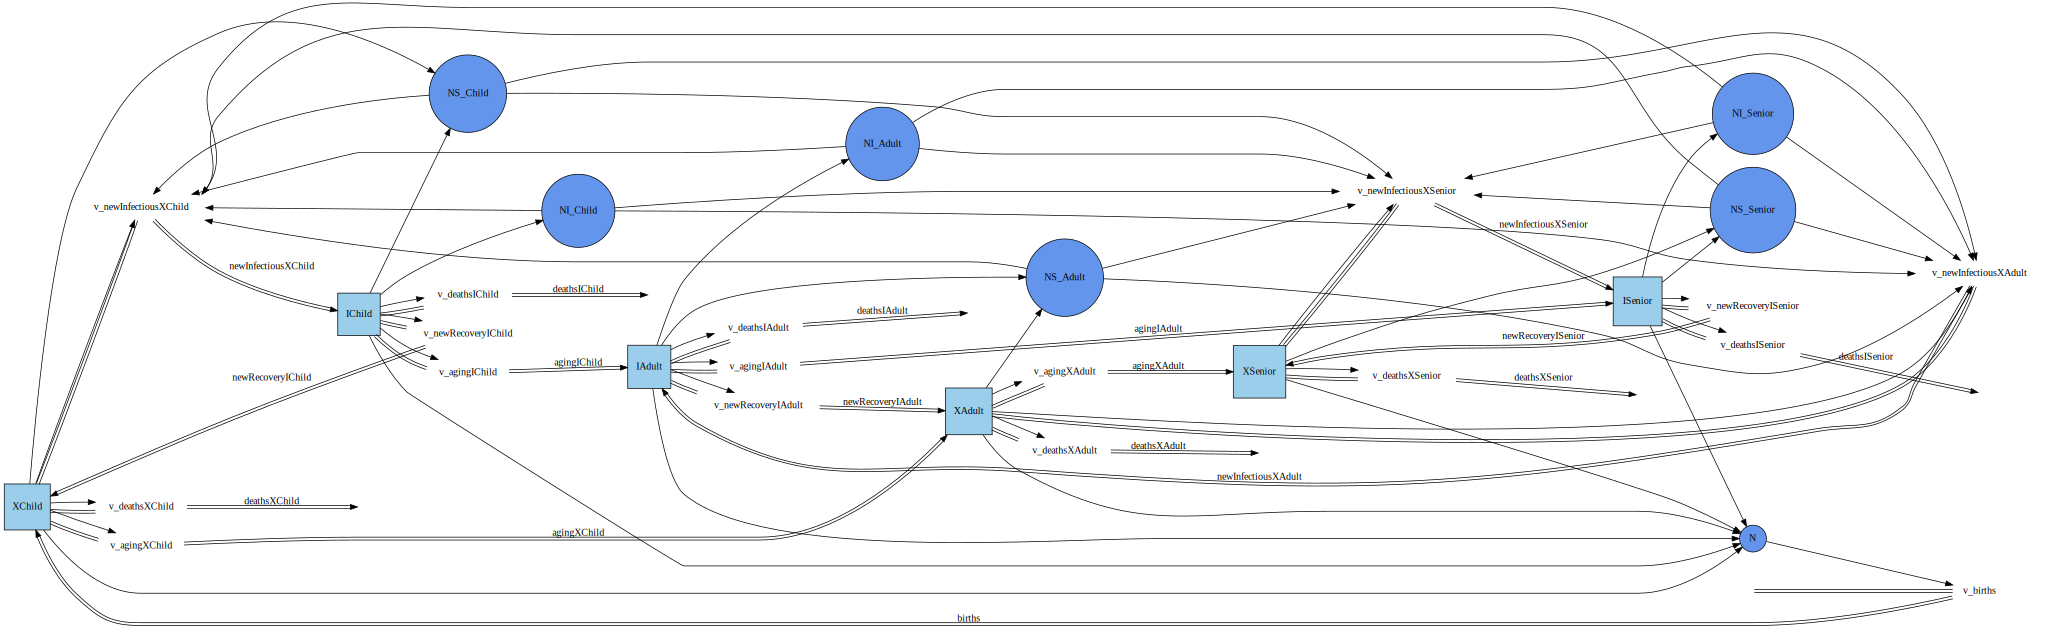

In [30]:
Graph(age_strata)

## 5.1 Homomorphism of the typed age strata model

In [31]:
typed_age_strata=ACSetTransformation(age_strata, SIS_type,
  S = [sX, sI, sX, sI, sX, sI],
  SV = [sv_N, sv_NI, sv_NS, sv_NI, sv_NS, sv_NI, sv_NS],
  LS = [lsn_X_NS, lsn_X_N, lsn_I_NS, lsn_I_NI, lsn_I_N, lsn_X_NS, lsn_X_N, lsn_I_NS, lsn_I_NI, lsn_I_N, lsn_X_NS, lsn_X_N, lsn_I_NS, lsn_I_NI, lsn_I_N],     
  F = [f_births, f_newInfectious, f_newInfectious, f_newInfectious, f_newRecovery, f_newRecovery, f_newRecovery, f_agingX, f_agingI, f_agingX, f_agingI, f_deathsX, f_deathsX, f_deathsX, f_deathsI, f_deathsI, f_deathsI],      
  I = [i_births, i_newRecovery, i_newInfectious, i_agingX, i_newRecovery, i_agingI, i_newInfectious, i_newRecovery, i_agingX, i_newInfectious, i_agingI], 
  O = [o_deathsX, o_agingX, o_newInfectious, o_newRecovery, o_agingI, o_deathsI, o_deathsX, o_agingX, o_newInfectious, o_newRecovery, o_agingI, o_deathsI, o_deathsX, o_newInfectious, o_newRecovery, o_deathsI],
  V = [v_births, v_newInfectious, v_newInfectious, v_newInfectious, v_newRecovery, v_newRecovery, v_newRecovery, v_agingX, v_agingI, v_agingX, v_agingI, v_deathsX, v_deathsX, v_deathsX, v_deathsI, v_deathsI, v_deathsI],      
  LV = [lv_deathsX, lv_agingX, lv_newInfectious, lv_newRecovery, lv_agingI, lv_deathsI, lv_deathsX, lv_agingX, lv_newInfectious, lv_newRecovery, lv_agingI, lv_deathsI, lv_deathsX, lv_newInfectious, lv_newRecovery, lv_deathsI],
  LSV = [lsv_N_births, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious],
  Name = name -> nothing  
)

ACSetTransformation((S = FinFunction([1, 2, 1, 2, 1, 2], 6, 2), SV = FinFunction([1, 2, 3, 2, 3, 2, 3], 7, 3), LS = FinFunction([1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5], 15, 5), F = FinFunction([2, 3, 3, 3, 4, 4, 4, 6, 7, 6, 7, 1, 1, 1, 5, 5, 5], 17, 7), I = FinFunction([1, 2, 4, 3, 2, 5, 4, 2, 3, 4, 5], 11, 5), O = FinFunction([1, 3, 2, 4, 6, 5, 1, 3, 2, 4, 6, 5, 1, 2, 4, 5], 16, 6), V = FinFunction([2, 3, 3, 3, 4, 4, 4, 6, 7, 6, 7, 1, 1, 1, 5, 5, 5], 17, 7), LV = FinFunction([1, 3, 2, 4, 6, 5, 1, 3, 2, 4, 6, 5, 1, 2, 4, 5], 16, 6), LSV = FinFunction([1, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3], 19, 3), Name = LooseVarFunction{Symbol, Nothing}(FinDomFunction(Union{Nothing, AttrVar}[], FinSet(0), TypeSet(Union{Nothing, AttrVar})), SetFunction(#34, TypeSet(Symbol), TypeSet(Nothing)), FinSet(0))), StockAndFlowStructure {S:6, SV:7, LS:15, F:17, I:11, O:16, V:17, LV:16, LSV:19, Name:0}, StockAndFlowStructureUntyped{Nothing} {S:2, SV:3, LS:5, F:7, I:5, O:6, V:7, LV:6, LSV:

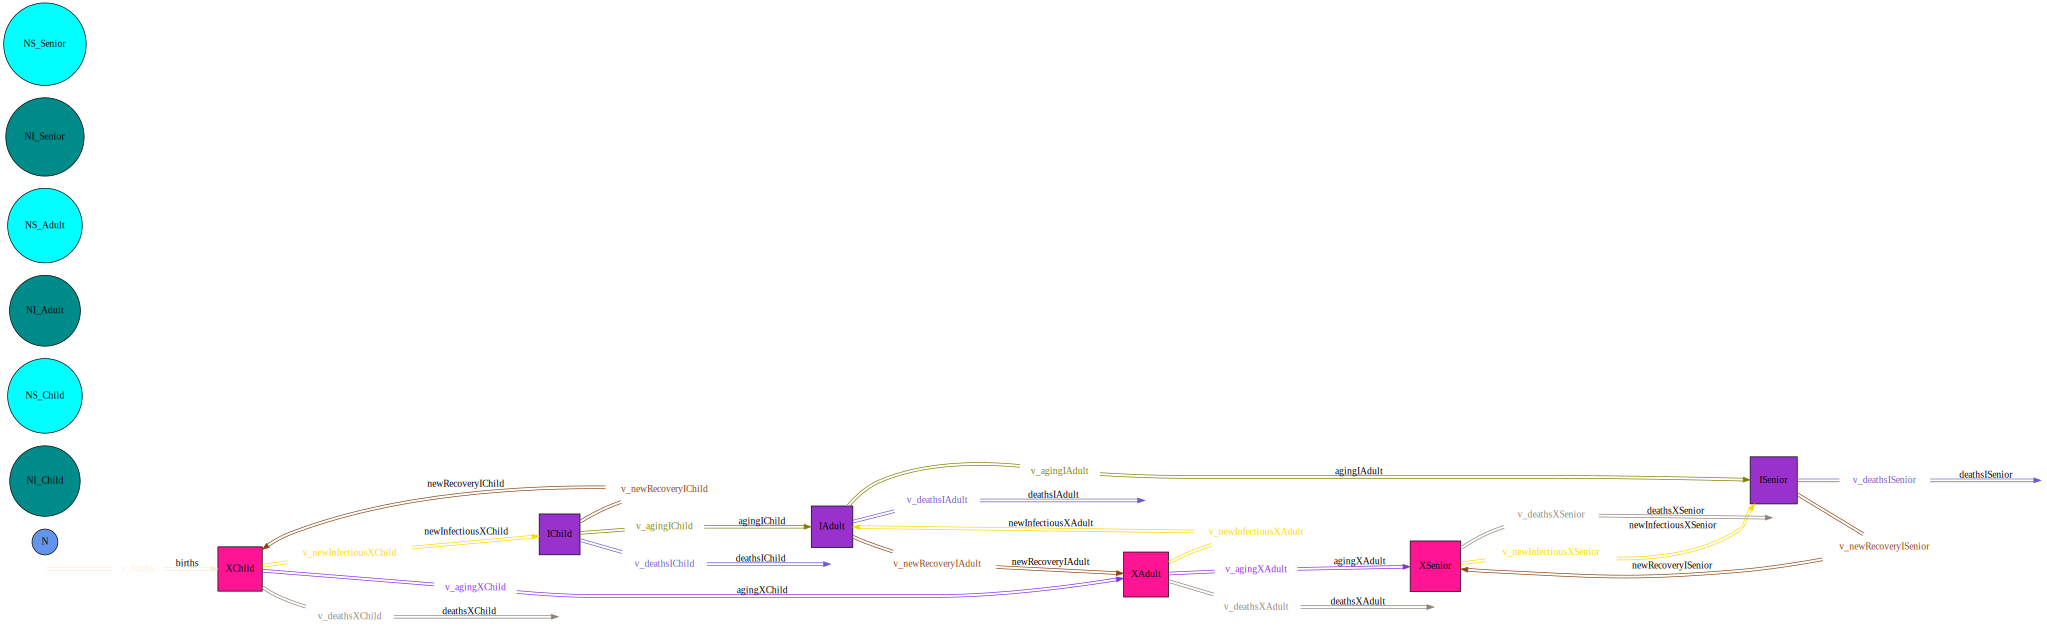

In [32]:
is_natural(typed_age_strata)
Graph_typed(typed_age_strata; type="SFV")

# 6. Build the stratified SIS model (by AGE dimension) using pull back

In [33]:
age_model = pullback(typed_aggregate_model, typed_age_strata)
apex(age_model)

S,sname
1,"(:X, :XChild)"
2,"(:A, :IChild)"
3,"(:Y, :IChild)"
4,"(:X, :XAdult)"
5,"(:A, :IAdult)"
6,"(:Y, :IAdult)"
7,"(:X, :XSenior)"
8,"(:A, :ISenior)"
9,"(:Y, :ISenior)"
SV,svname


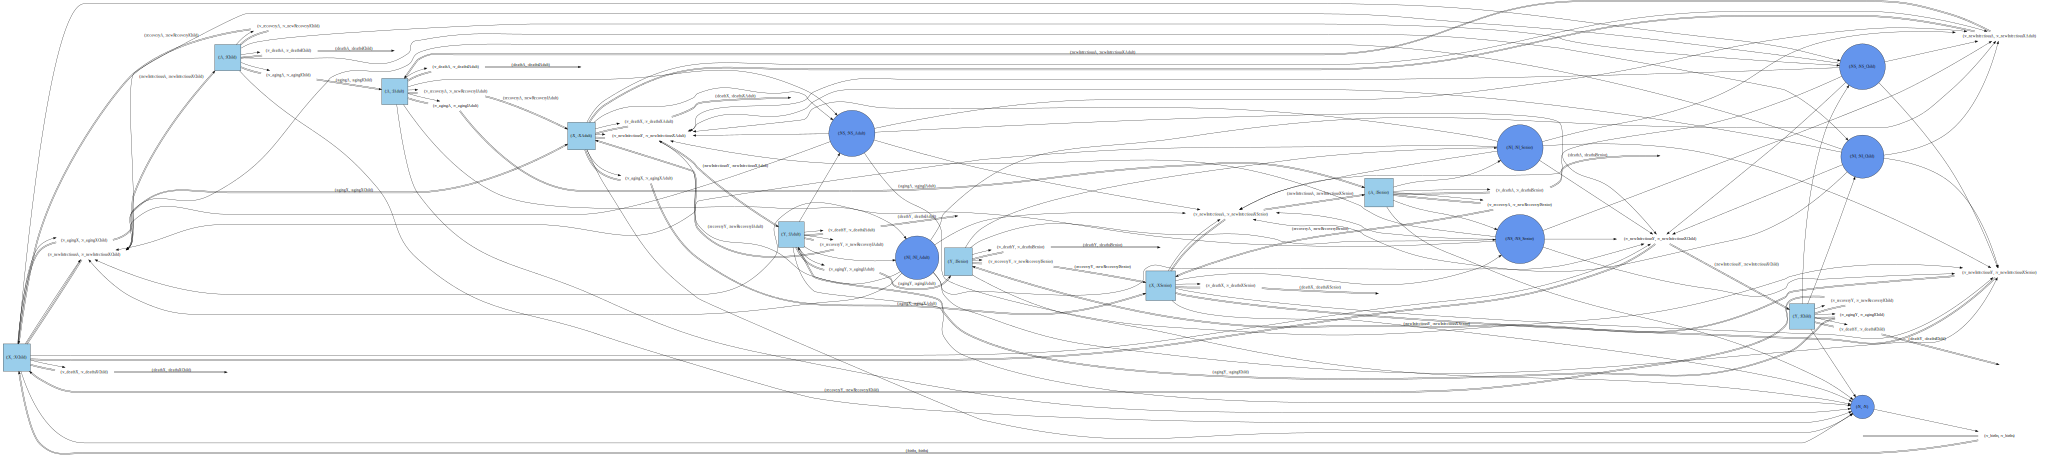

In [34]:
Graph(apex(age_model))

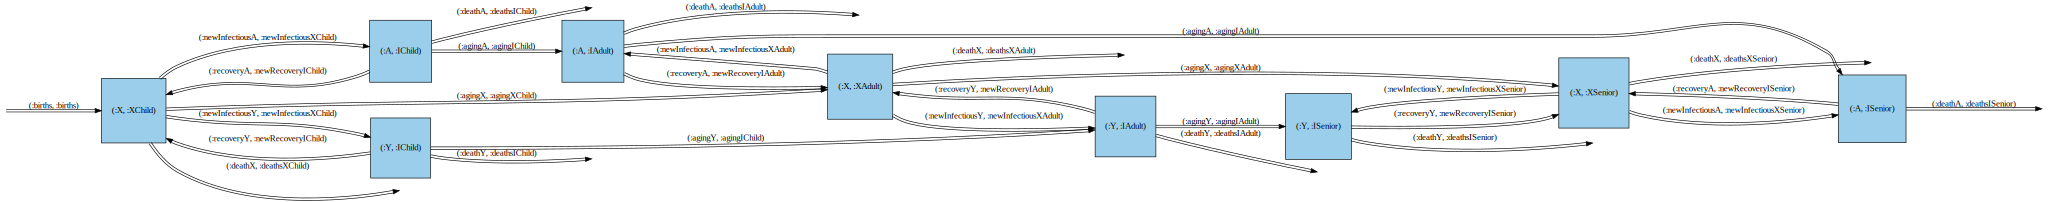

In [35]:
Graph(apex(age_model),type="SF")

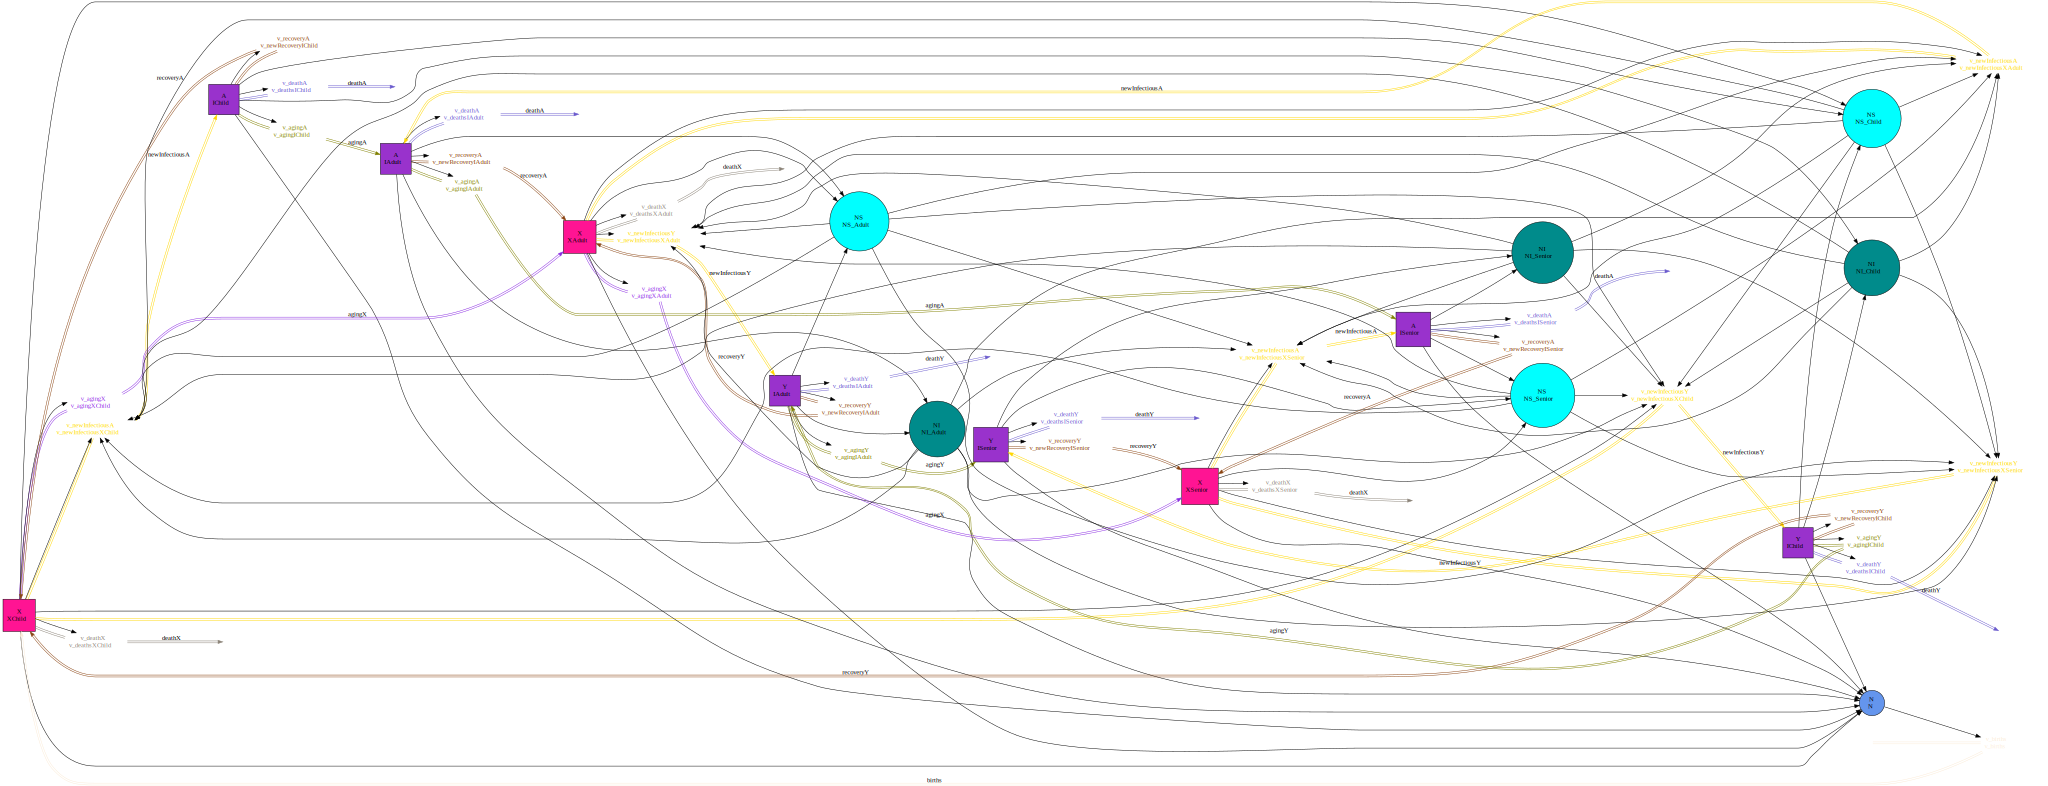

In [36]:
typed_age_model = typed_stratify(typed_aggregate_model, typed_age_strata)
Graph_typed(typed_age_model)

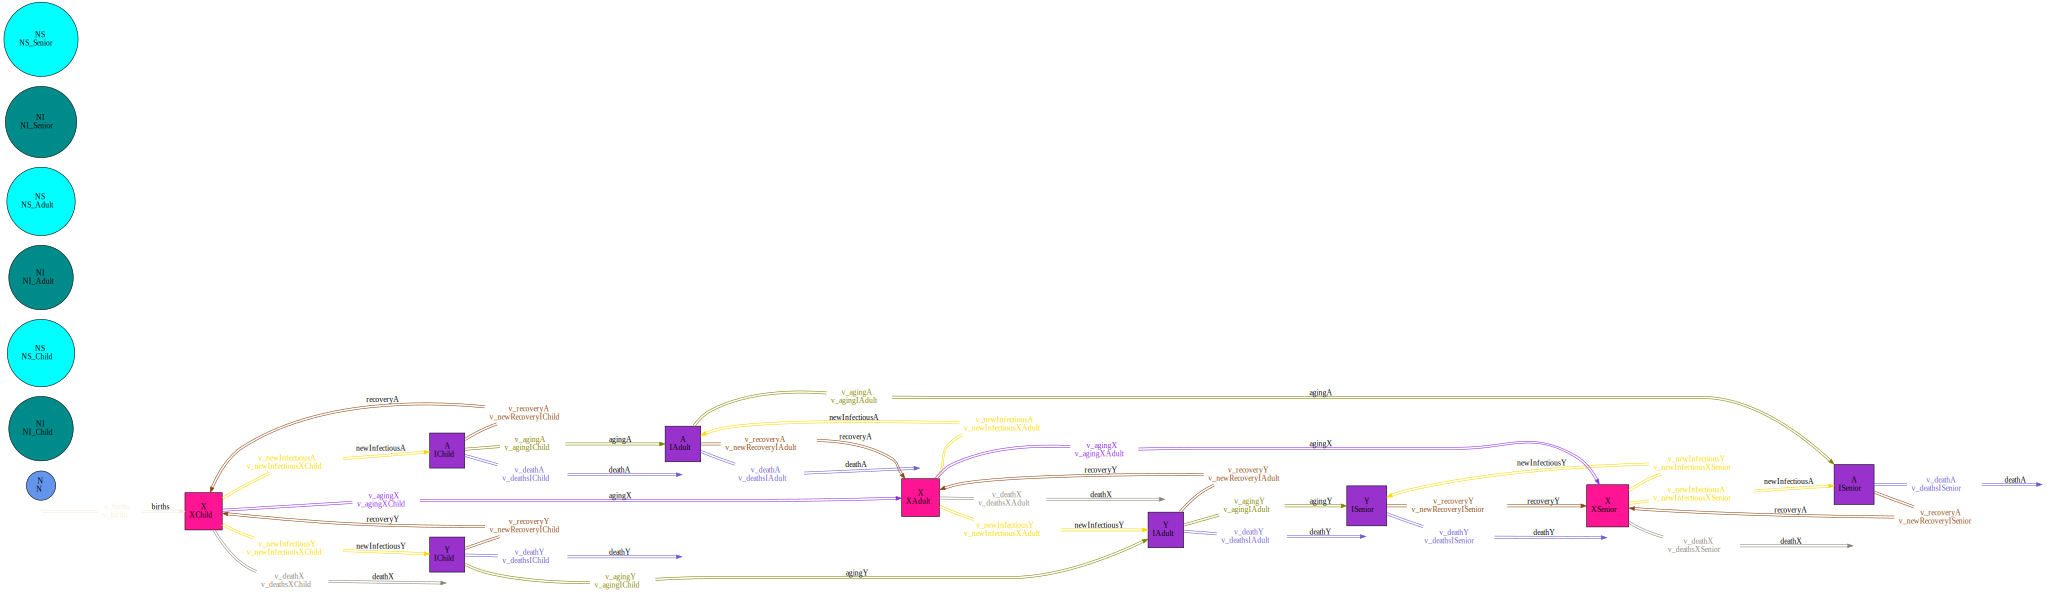

In [37]:
Graph_typed(typed_age_model;type="SFV")

# 7. Stratified by two dimensions: age and sex

## 7.1 Redefine the sex strata model
We need to redefine the homomorphism of typed_sex_strata including "aging" flows, or the aging flows will not be generated!!

In [38]:
## 
#(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"
sex_strata_for_incorate_age=StockAndFlowStructure(
    (:XF=>((:birthsF, :newRecoveryF, :agingXF),(:deathsXF, :newInfectiousF, :agingXF),(:v_deathsXF, :v_newInfectiousF, :v_agingXF),(:NS_F,:N)),
        :IF=>((:newInfectiousF, :agingIF),(:newRecoveryF, :deathsIF, :agingIF),(:v_newRecoveryF, :v_deathsIF, :v_agingIF),(:NS_F,:NI_F,:N)),
        :XM=>((:birthsM, :newRecoveryM, :agingXM),(:deathsXM, :newInfectiousM, :agingXM),(:v_deathsXM, :v_newInfectiousM, :v_agingXM),(:NS_M,:N)),
        :IM=>((:newInfectiousM, :agingIM),(:newRecoveryM, :deathsIM, :agingIM),(:v_newRecoveryM, :v_deathsIM, :v_agingIM),(:NS_M,:NI_M,:N))),
    (:birthsF=>:v_birthsF, :newRecoveryF=>:v_newRecoveryF, :newInfectiousF=>:v_newInfectiousF, :deathsXF=>:v_deathsXF, :deathsIF=>:v_deathsIF,
     :birthsM=>:v_birthsM, :newRecoveryM=>:v_newRecoveryM, :newInfectiousM=>:v_newInfectiousM, :deathsXM=>:v_deathsXM, :deathsIM=>:v_deathsIM,
     :agingIF=>:v_agingIF, :agingXF=>:v_agingXF, :agingIM=>:v_agingIM, :agingXM=>:v_agingXM),
    (:N=>(:v_birthsF,:v_birthsM), :NI_F=>(:v_newInfectiousF,:v_newInfectiousM), :NS_F=>(:v_newInfectiousF,:v_newInfectiousM),
                                  :NI_M=>(:v_newInfectiousF,:v_newInfectiousM), :NS_M=>(:v_newInfectiousF,:v_newInfectiousM))
)

S,sname
1,XF
2,IF
3,XM
4,IM
SV,svname
1,N
2,NI_F
3,NS_F
4,NI_M
5,NS_M


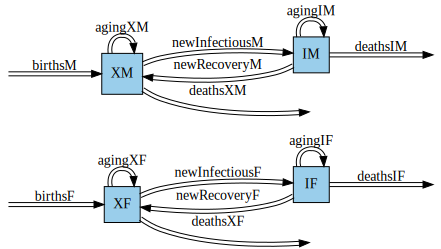

In [39]:
Graph(sex_strata_for_incorate_age,type="SF")

## 7.2 Homomorphism of redefined typed sex model for incorporating with age strata

In [40]:
typed_sex_strata_for_incorate_age=ACSetTransformation(sex_strata_for_incorate_age, SIS_type,
  S = [sX, sI, sX, sI],
  SV = [sv_N, sv_NI, sv_NS, sv_NI, sv_NS],
  LS = [lsn_X_NS, lsn_X_N, lsn_I_NS, lsn_I_NI, lsn_I_N, lsn_X_NS, lsn_X_N, lsn_I_NS, lsn_I_NI, lsn_I_N],     
  F = [f_births, f_newRecovery, f_newInfectious, f_deathsX, f_deathsI, f_births, f_newRecovery, f_newInfectious, f_deathsX, f_deathsI, f_agingI, f_agingX, f_agingI, f_agingX],      
  I = [i_births, i_newRecovery, i_agingX, i_newInfectious, i_agingI, i_births, i_newRecovery, i_agingX, i_newInfectious, i_agingI], 
  O = [o_deathsX, o_newInfectious, o_agingX, o_newRecovery, o_deathsI, o_agingI, o_deathsX, o_newInfectious, o_agingX, o_newRecovery, o_deathsI, o_agingI],
  V = [v_births, v_newRecovery, v_newInfectious, v_deathsX, v_deathsI, v_births, v_newRecovery, v_newInfectious, v_deathsX, v_deathsI, v_agingI, v_agingX, v_agingI, v_agingX],      
  LV = [lv_deathsX, lv_newInfectious, lv_agingX, lv_newRecovery, lv_deathsI, lv_agingI, lv_deathsX, lv_newInfectious, lv_agingX, lv_newRecovery, lv_deathsI, lv_agingI],
  LSV = [lsv_N_births, lsv_N_births, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious],
  Name = name -> nothing  
)

ACSetTransformation((S = FinFunction([1, 2, 1, 2], 4, 2), SV = FinFunction([1, 2, 3, 2, 3], 5, 3), LS = FinFunction([1, 2, 3, 4, 5, 1, 2, 3, 4, 5], 10, 5), F = FinFunction([2, 4, 3, 1, 5, 2, 4, 3, 1, 5, 7, 6, 7, 6], 14, 7), I = FinFunction([1, 2, 3, 4, 5, 1, 2, 3, 4, 5], 10, 5), O = FinFunction([1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6], 12, 6), V = FinFunction([2, 4, 3, 1, 5, 2, 4, 3, 1, 5, 7, 6, 7, 6], 14, 7), LV = FinFunction([1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6], 12, 6), LSV = FinFunction([1, 1, 2, 2, 3, 3, 2, 2, 3, 3], 10, 3), Name = LooseVarFunction{Symbol, Nothing}(FinDomFunction(Union{Nothing, AttrVar}[], FinSet(0), TypeSet(Union{Nothing, AttrVar})), SetFunction(#36, TypeSet(Symbol), TypeSet(Nothing)), FinSet(0))), StockAndFlowStructure {S:4, SV:5, LS:10, F:14, I:10, O:12, V:14, LV:12, LSV:10, Name:0}, StockAndFlowStructureUntyped{Nothing} {S:2, SV:3, LS:5, F:7, I:5, O:6, V:7, LV:6, LSV:3, Name:0})

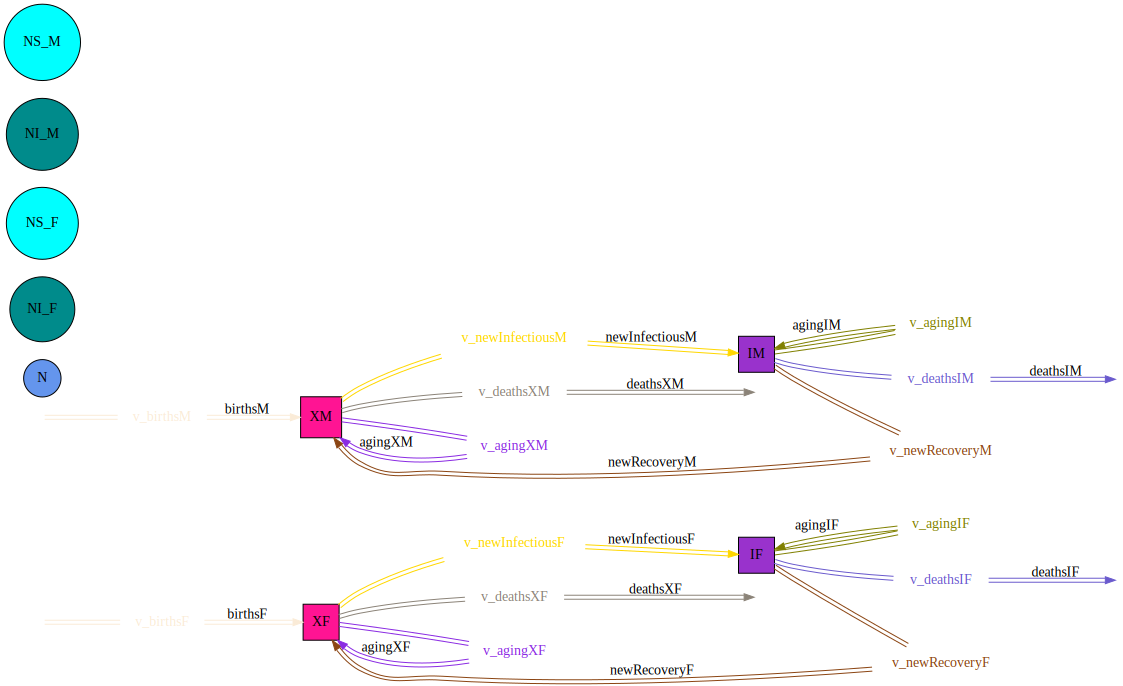

In [41]:
is_natural(typed_sex_strata_for_incorate_age)
Graph_typed(typed_sex_strata_for_incorate_age; type="SFV")

# 8. Build the stratified SIS model (by both SEX and AGE dimensions) using pull back

In [42]:
sex_age_model = pullback([typed_aggregate_model, typed_sex_strata_for_incorate_age, typed_age_strata])
apex(sex_age_model)

S,sname
1,"(:X, :XF, :XChild)"
2,"(:X, :XM, :XChild)"
3,"(:A, :IF, :IChild)"
4,"(:Y, :IF, :IChild)"
5,"(:A, :IM, :IChild)"
6,"(:Y, :IM, :IChild)"
7,"(:X, :XF, :XAdult)"
8,"(:X, :XM, :XAdult)"
9,"(:A, :IF, :IAdult)"
10,"(:Y, :IF, :IAdult)"


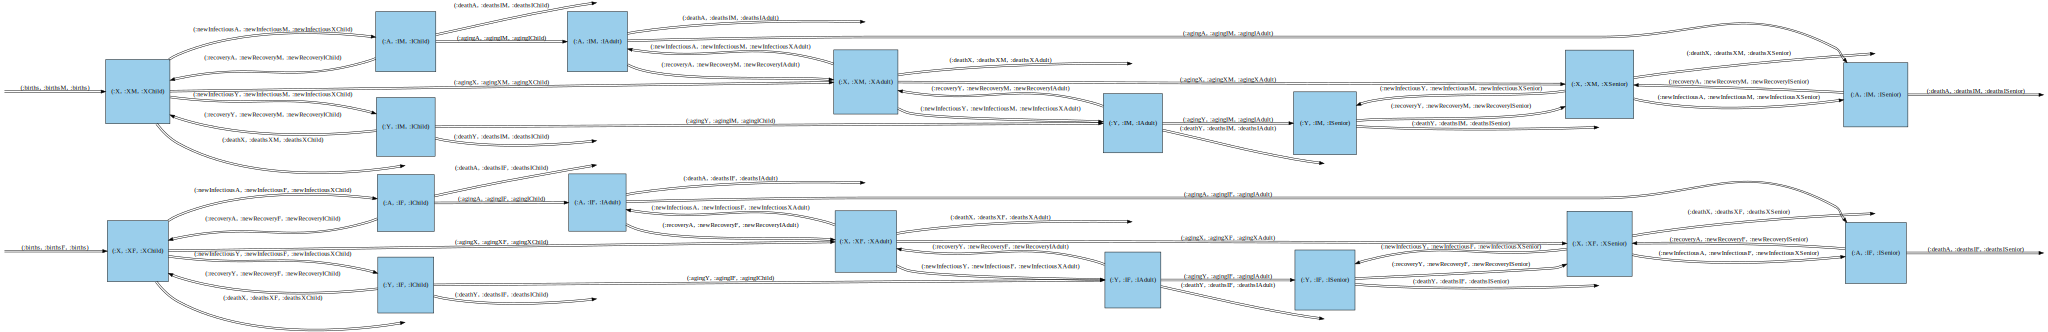

In [43]:
Graph(apex(sex_age_model),type="SF")

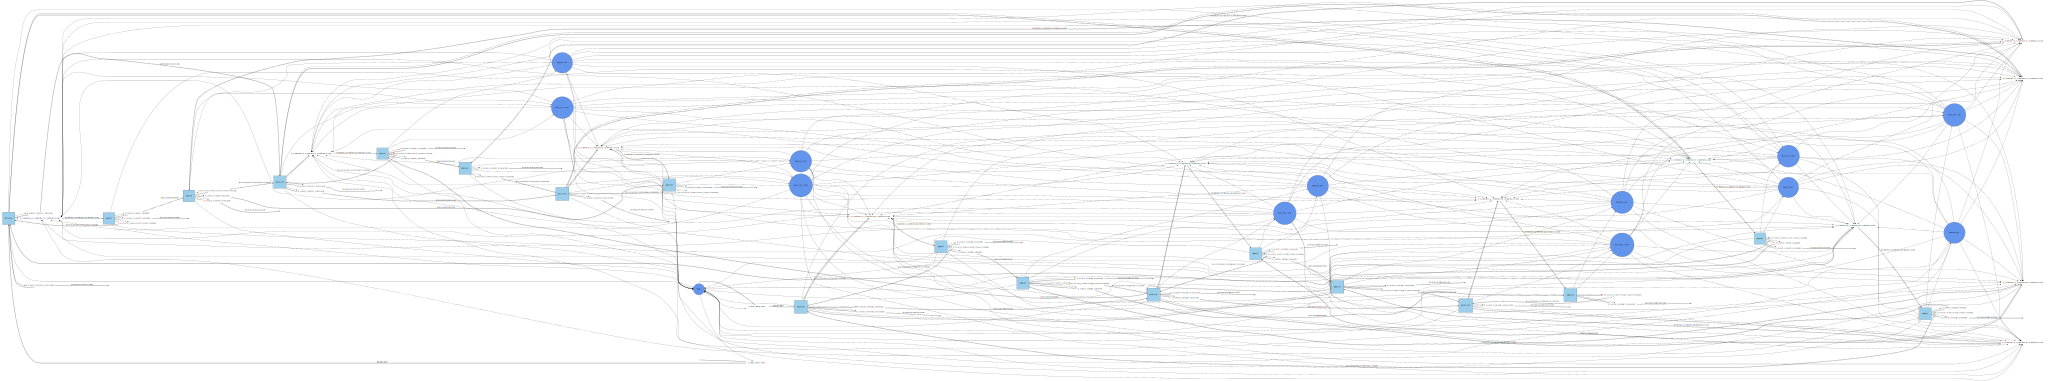

In [44]:
Graph(apex(sex_age_model))

In [45]:
# Plot the typed stock and flow diagram
stratify(typed_models...) = ob(pullback(collect(typed_models)))

typed_stratify(typed_models...) =
  compose(legs(pullback(collect(typed_models)))[1], typed_models[1]);

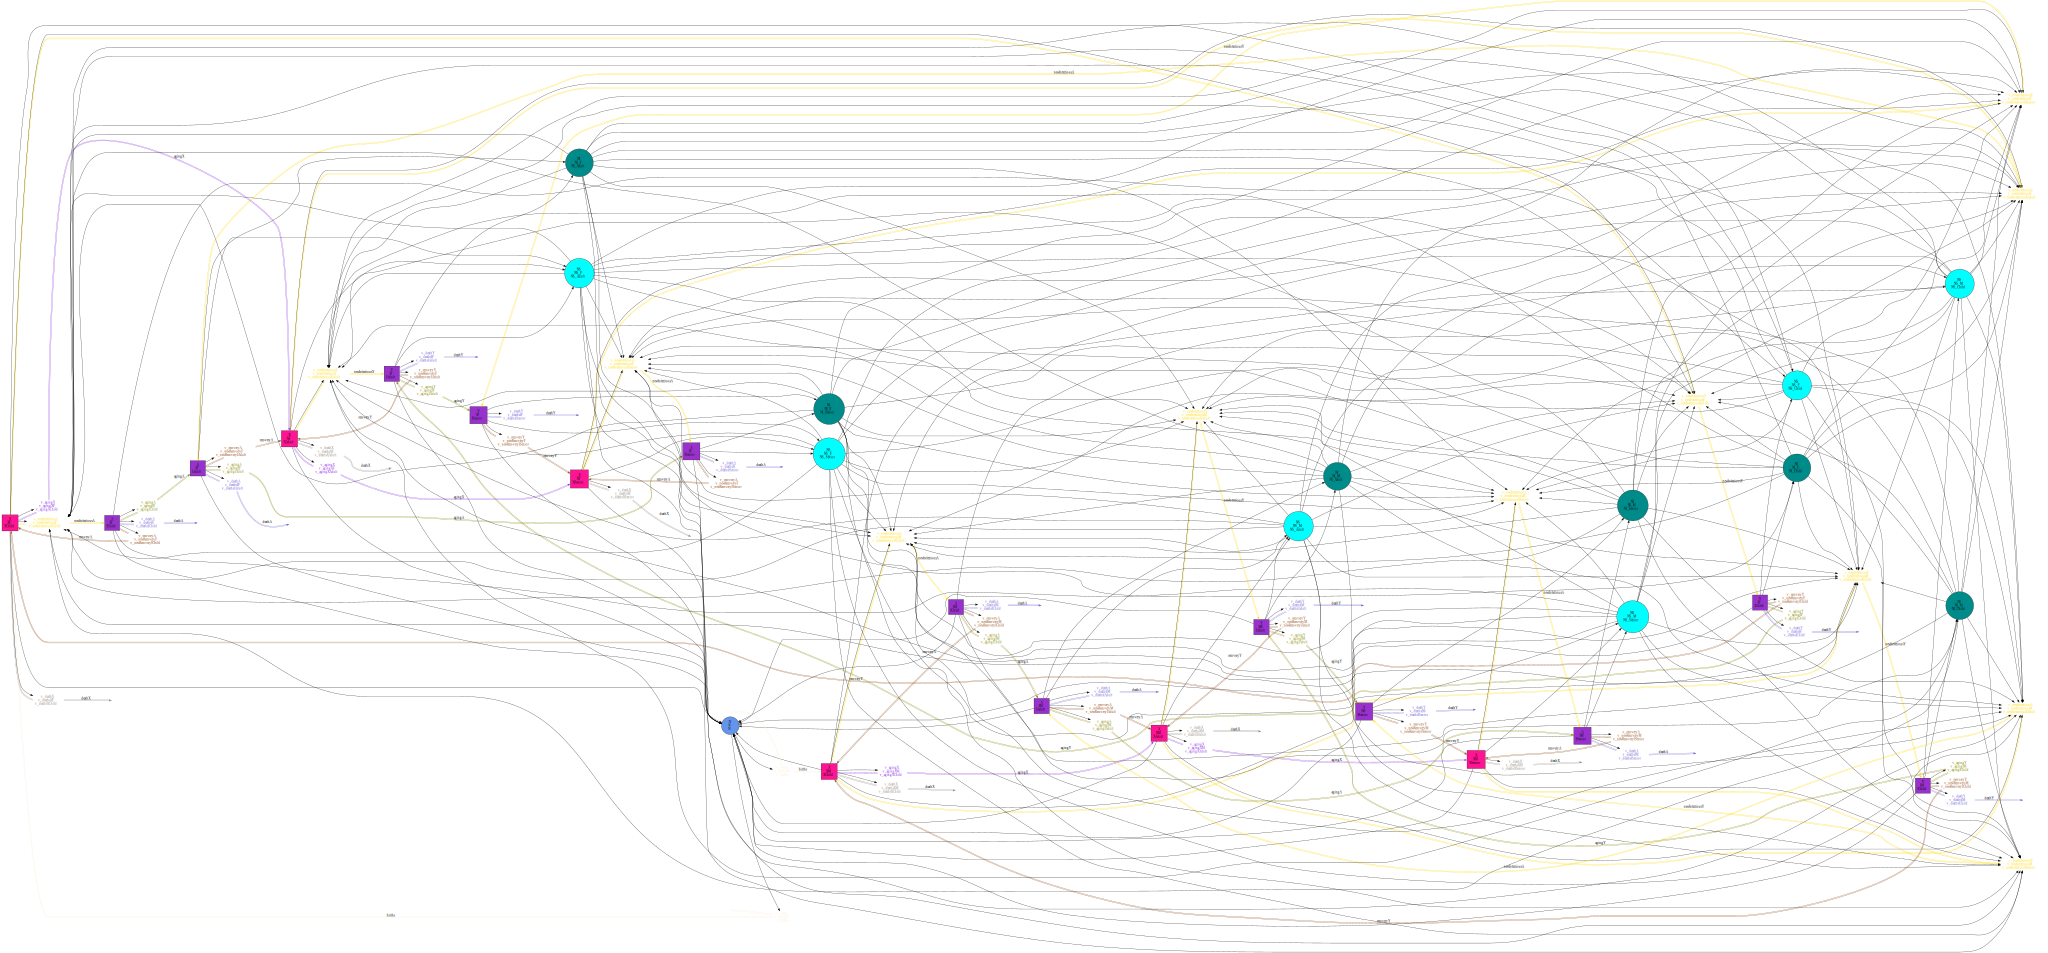

In [46]:
Graph_typed(typed_stratify(typed_aggregate_model, typed_sex_strata_for_incorate_age, typed_age_strata))

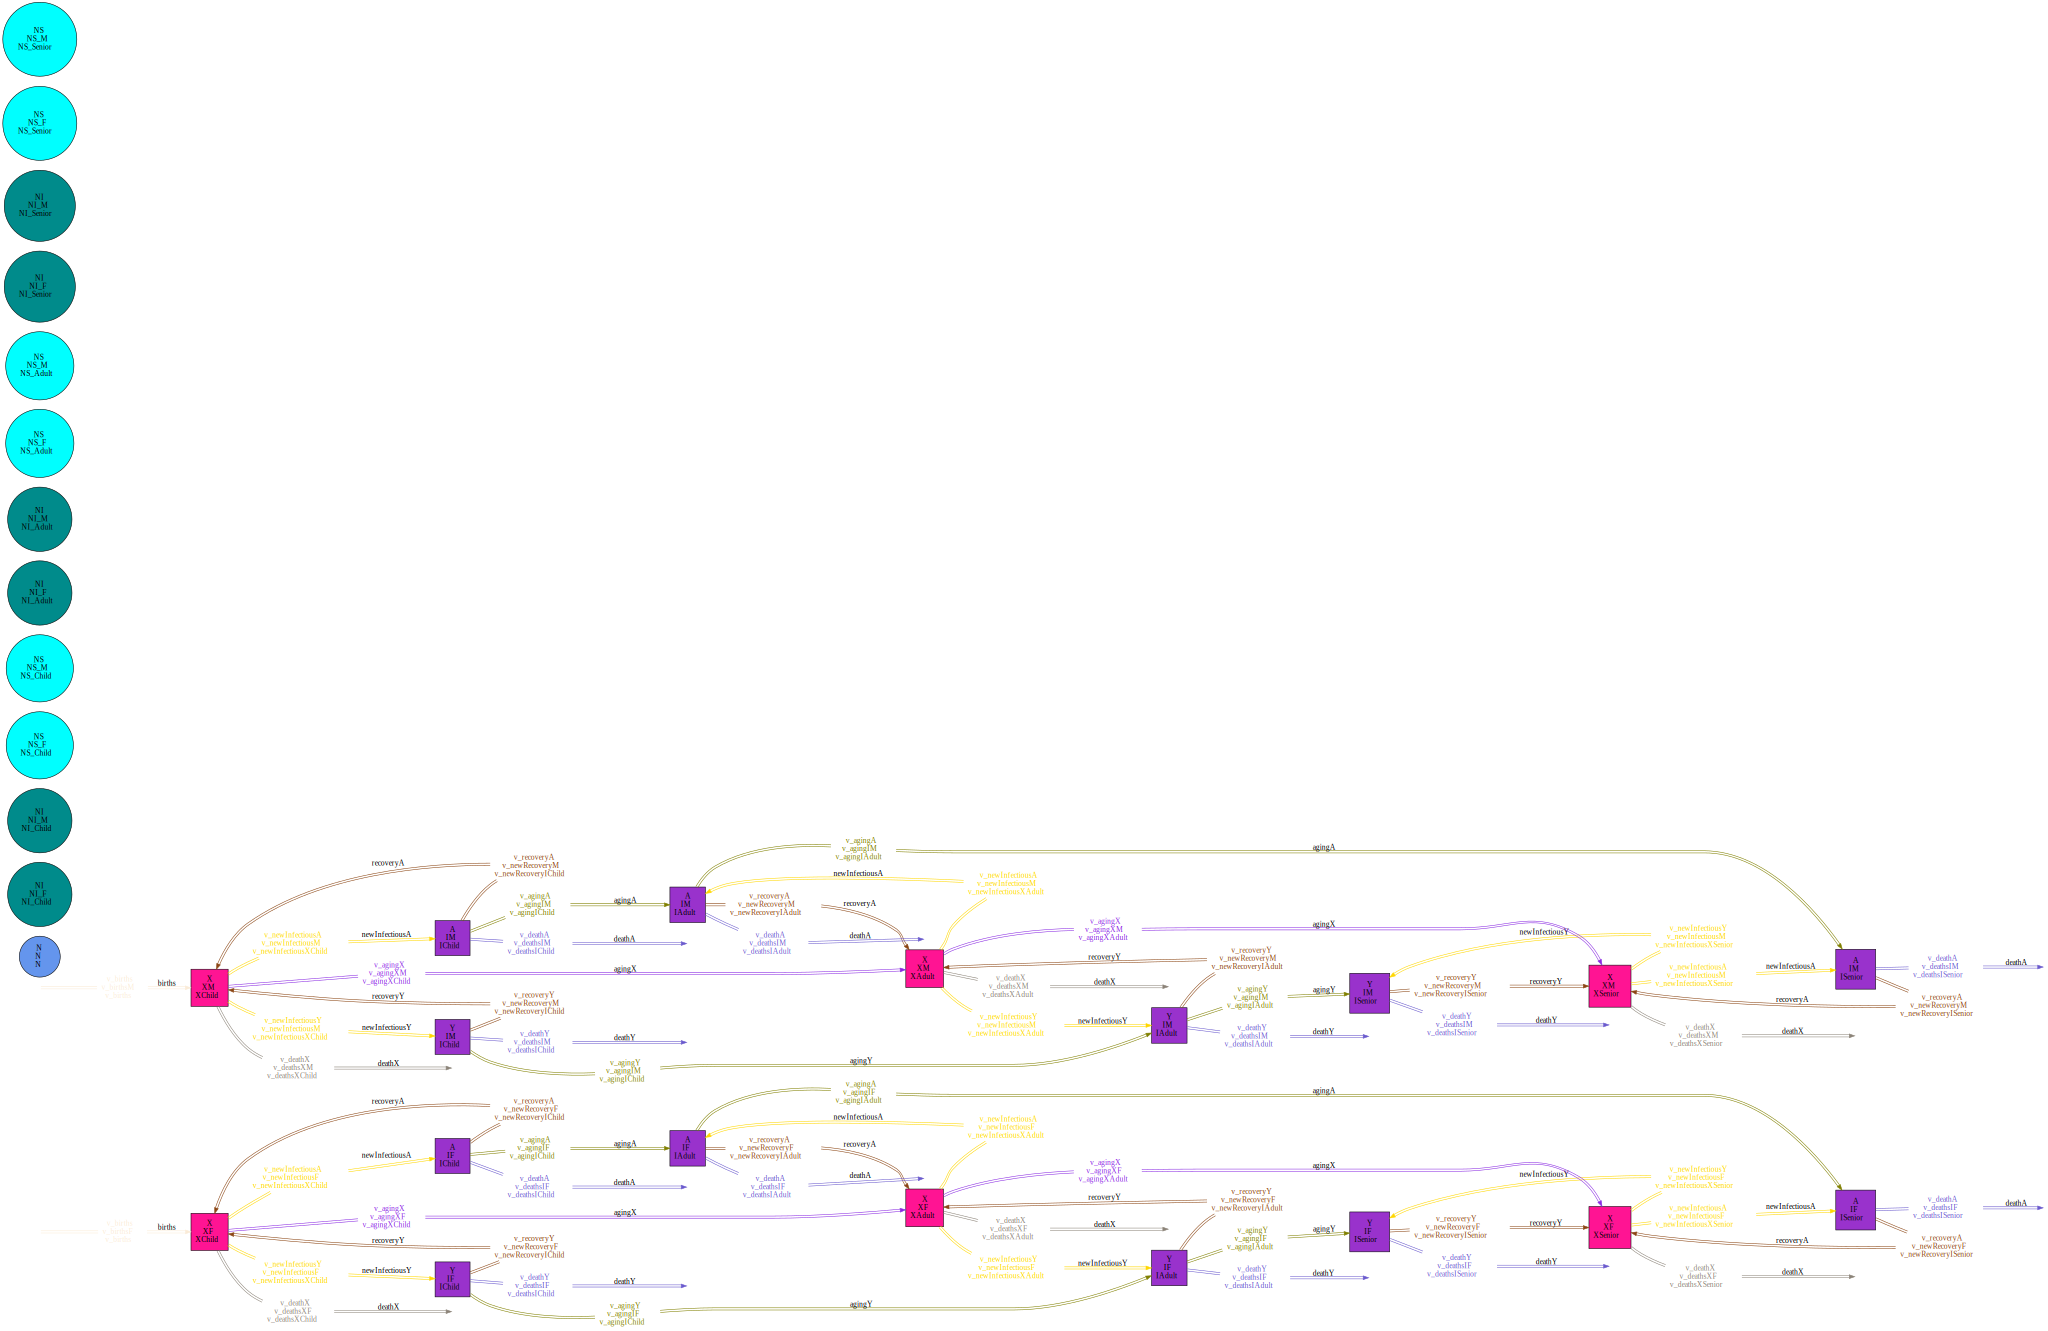

In [47]:
Graph_typed(typed_stratify(typed_aggregate_model, typed_sex_strata_for_incorate_age, typed_age_strata);type="SFV")

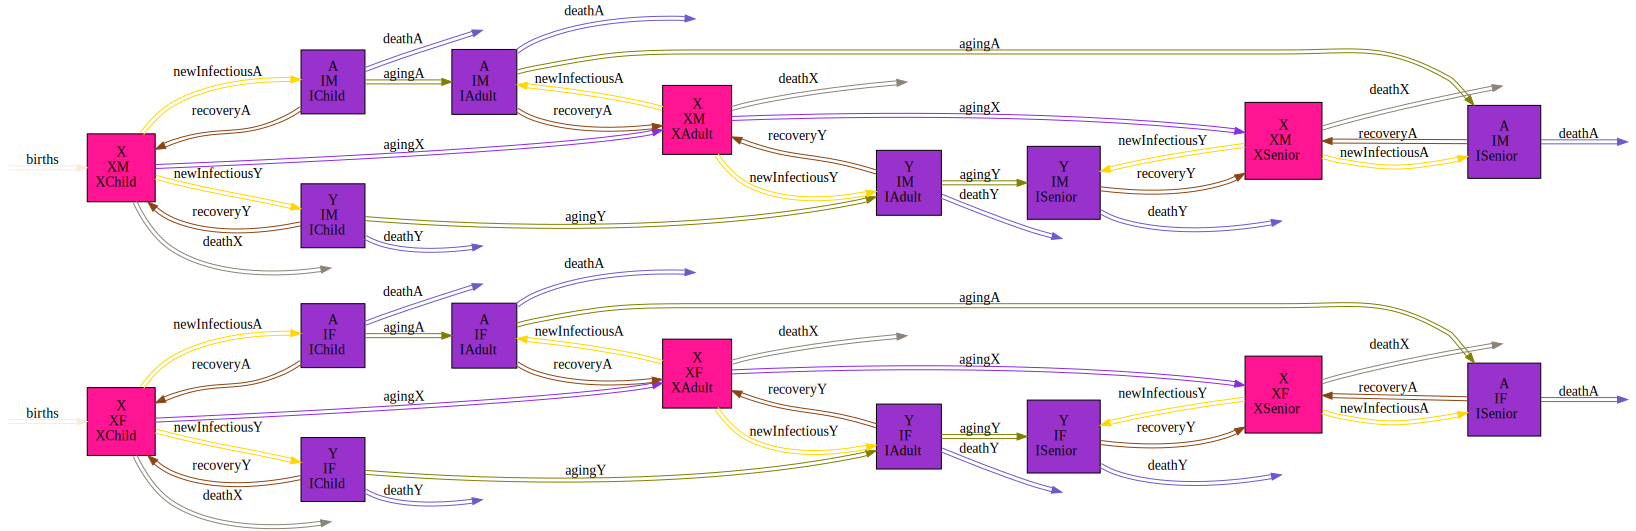

In [48]:
Graph_typed(typed_stratify(typed_aggregate_model, typed_sex_strata_for_incorate_age, typed_age_strata);type="SF")

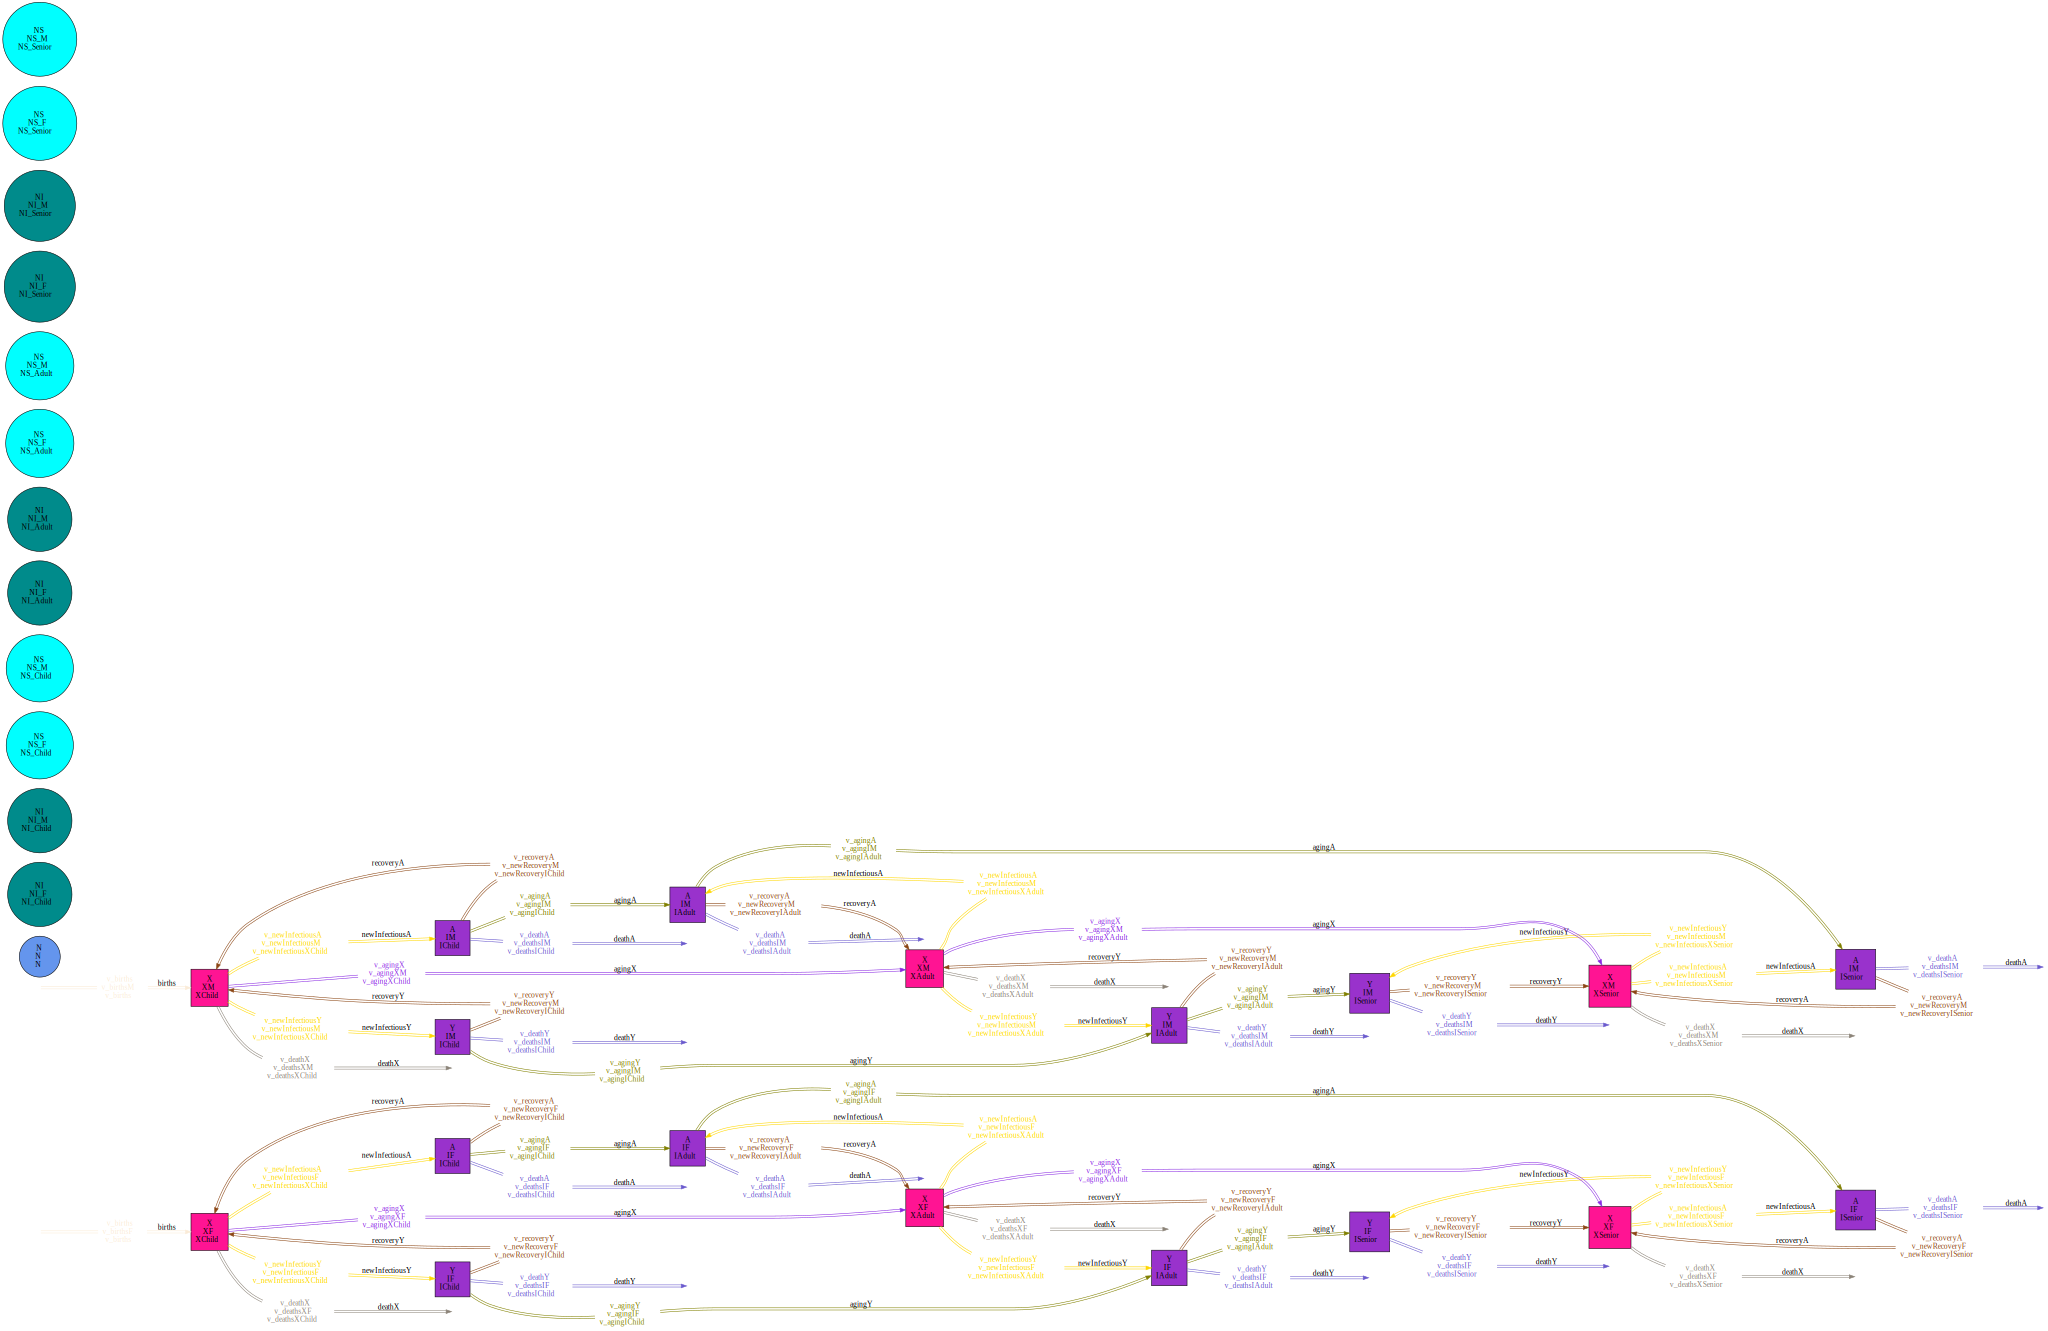

In [49]:
Graph_typed(typed_stratify(typed_aggregate_model, typed_sex_strata_for_incorate_age, typed_age_strata);type="SFV")